<a href="https://colab.research.google.com/github/giulioalbano1994/bot_data_visualization_giulio-albano/blob/main/PL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PL3

### Estensione soglie

In [ ]:
# ============================================
# PL4 – STEP 1: packages + load all datasets
# ============================================

import warnings
from pathlib import Path
import pandas as pd
import numpy as np

warnings.filterwarnings("ignore", category=FutureWarning)

# --- Config ---
PATHS = dict(
    thresholds_parquet = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/dati soglie di povertà/soglie_povass_2014_2021_light.parquet",

    cpt_spending_main = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/cpt_three_services_full.parquet",
    cpt_spending_fallback_parquet = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/CPT_spese_2014_2021_clean.parquet",
    cpt_spending_fallback_csv = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/CPT_spese_2014_2021_clean.csv",

    efficiency_parquet = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/efficienze/efficienze_2014_2021.parquet",
    efficiency_csv = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/efficienze/efficienze_2014_2021.csv",

    age_need_weights_csv = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/fabbisogni_fasce_2025.csv",

    typology_age_profile_parquet = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/Weights/typology_age_profile.parquet",

    nearpoverty_parquet = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/hsp_pov_merg.parquet",

    out_dir = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline3_multi",
)

Path(PATHS['out_dir']).mkdir(parents=True, exist_ok=True)

YEARS = list(range(2014, 2022))
SERVICES = ["health", "education", "tpl"]
BENCHMARK_MODE = "top20"
USE_EFFICIENCY = True
PRUDENTIAL_NO_DECREASE = True

THRESHOLDS_COLS = dict(
    year_col="anno",
    region_col="rgn",
    typology_col="codice_tipologia_famiglia",
    threshold_value_col="soglia_euro"
)

SAVE_INTERMEDIATE = True


# -----------------------------
# Helpers
# -----------------------------
def _exists(p):
    return p and Path(p).exists()

def read_parquet_or_csv(parquet_path, csv_path=None):
    if _exists(parquet_path):
        return pd.read_parquet(parquet_path)
    if csv_path and _exists(csv_path):
        return pd.read_csv(csv_path)
    raise ValueError(f"Nessun file trovato:\n{parquet_path}\n{csv_path}")

def normalize_year(df, candidates=("year","anno","Anno")):
    for c in candidates:
        if c in df.columns:
            df["year"] = pd.to_numeric(df[c], errors="coerce").astype("Int64")
            return df
    return df

def normalize_rgn(df, candidates=("rgn","reg","Regione","regione","region","COD_REG","cod_reg")):
    for c in candidates:
        if c in df.columns:
            df["rgn"] = df[c].astype(str).str.strip()
            return df
    return df

def quick_profile(name, df):
    nrows, ncols = df.shape
    years = df["year"].dropna().unique() if "year" in df.columns else []
    y_min = int(pd.Series(years).min()) if len(years) else None
    y_max = int(pd.Series(years).max()) if len(years) else None
    rgn_n = df["rgn"].nunique() if "rgn" in df.columns else None
    return f"[{name}] ✓ shape=({nrows},{ncols}) years={y_min}–{y_max} regions={rgn_n}"

# Filtro per escludere regioni speciali
EXCLUDE_REGIONS = [
    "Valle d'Aosta",
    "Trentino-Alto Adige",
    "Provincia Autonoma di Bolzano",
    "Provincia Autonoma di Trento"
]

def exclude_special_regions(df):
    if "rgn" in df.columns:
        return df[~df["rgn"].isin(EXCLUDE_REGIONS)].copy()
    return df


# -----------------
# Caricamento
# -----------------
print("▶️ Caricamento dataset…")

thresholds_df = read_parquet_or_csv(PATHS["thresholds_parquet"])
thresholds_df = normalize_year(thresholds_df, ("anno","year","Anno"))
thresholds_df = normalize_rgn(thresholds_df)
thresholds_df = exclude_special_regions(thresholds_df)

try:
    cpt_df = read_parquet_or_csv(PATHS["cpt_spending_main"])
except ValueError:
    cpt_df = read_parquet_or_csv(PATHS["cpt_spending_fallback_parquet"], PATHS["cpt_spending_fallback_csv"])
cpt_df = normalize_year(cpt_df)
cpt_df = normalize_rgn(cpt_df)
cpt_df = exclude_special_regions(cpt_df)

eff_df = read_parquet_or_csv(PATHS["efficiency_parquet"], PATHS["efficiency_csv"])
eff_df = normalize_year(eff_df)
eff_df = normalize_rgn(eff_df)
eff_df = exclude_special_regions(eff_df)

age_need_df = pd.read_csv(PATHS["age_need_weights_csv"])
typology_age_profile_df = pd.read_parquet(PATHS["typology_age_profile_parquet"])

# ********************************************************************************
# 🐞 FIX CRITICA UNICA: Assicuriamo che la chiave di merge sia STRINGA
# Questo è l'approccio più sicuro quando il merge numerico fallisce.
typology_age_profile_df['codice_tipologia_famiglia'] = typology_age_profile_df['codice_tipologia_famiglia'].astype(str)
# ********************************************************************************


nearpoverty_df = pd.read_parquet(PATHS["nearpoverty_parquet"])
nearpoverty_df = normalize_year(nearpoverty_df)
nearpoverty_df = normalize_rgn(nearpoverty_df)
nearpoverty_df = exclude_special_regions(nearpoverty_df)

# -----------------
# Profilo rapido
# -----------------
print("\n✅ Caricamento completato:")
for name, df in [
    ("thresholds_df", thresholds_df),
    ("cpt_df", cpt_df),
    ("eff_df", eff_df),
    ("age_need_df", age_need_df),
    ("typology_age_profile_df", typology_age_profile_df),
    ("nearpoverty_df", nearpoverty_df),
]:
    print(quick_profile(name, df))

PL4_DATA = dict(
    thresholds=thresholds_df,
    cpt=cpt_df,
    efficiency=eff_df,
    age_need=age_need_df,
    typology_age_profile=typology_age_profile_df,
    nearpoverty=nearpoverty_df,
    meta=dict(
        YEARS=YEARS,
        SERVICES=SERVICES,
        BENCHMARK_MODE=BENCHMARK_MODE,
        USE_EFFICIENCY=USE_EFFICIENCY,
        PRUDENTIAL_NO_DECREASE=PRUDENTIAL_NO_DECREASE,
        THRESHOLDS_COLS=THRESHOLDS_COLS,
        SAVE_INTERMEDIATE=SAVE_INTERMEDIATE,
        OUT_DIR=PATHS["out_dir"],
    )
)


▶️ Caricamento dataset…

✅ Caricamento completato:
[thresholds_df] ✓ shape=(24000,16) years=None–None regions=None
[cpt_df] ✓ shape=(5514,11) years=2000–2021 regions=18
[eff_df] ✓ shape=(144,6) years=2014–2021 regions=18
[age_need_df] ✓ shape=(7,4) years=None–None regions=None
[typology_age_profile_df] ✓ shape=(42,8) years=None–None regions=None
[nearpoverty_df] ✓ shape=(2647,84) years=None–None regions=20


In [ ]:
# ============================================
# PL4 – STEP 2: esplorazione DataFrame chiave
# ============================================

dfs_to_check = {
    "cpt_df": cpt_df,
    "eff_df": eff_df,
    "age_need_df": age_need_df,
    "typology_age_profile_df": typology_age_profile_df
}

for name, df in dfs_to_check.items():
    print(f"\n🔎 {name}")
    print("="*60)
    print("Shape:", df.shape)
    print("Colonne:", df.columns.tolist())
    print("\nPrime righe:")
    display(df.head(5))

    # Extra checks mirati
    if "year" in df.columns:
        print("Anni disponibili:", sorted(df["year"].dropna().unique())[:10], "...")
    if "rgn" in df.columns:
        print("Regioni uniche (prime 10):", sorted(df["rgn"].dropna().unique())[:10])
    if "servizio" in df.columns:
        print("Servizi unici:", df["servizio"].dropna().unique())
    if "Fascia" in df.columns:
        print("Fasce età:", df["Fascia"].dropna().unique())
    if "codice_tipologia_famiglia" in df.columns:
        print("Esempio tipologie:", df["codice_tipologia_famiglia"].dropna().unique()[:10])



🔎 cpt_df
Shape: (5514, 11)
Colonne: ['Territorio', 'Regione per Dettaglio', 'Settore', 'Tipologia di Soggetti', 'Categoria Spese', 'Anno', 'S - Consolidato SPA', 'servizio', 'reg', 'year', 'rgn']

Prime righe:


,Territorio,Regione per Dettaglio,Settore,Tipologia di Soggetti,Categoria Spese,Anno,S - Consolidato SPA,servizio,reg,year,rgn
234,91 - Centro-Nord,01 - Piemonte,00005 - Istruzione,Amministrazioni Centrali,S - 373 - TOTALE SPESE CORRENTE,2000,1514.59063,istruzione,Piemonte,2000,Piemonte
235,91 - Centro-Nord,01 - Piemonte,00005 - Istruzione,Amministrazioni Centrali,S - 373 - TOTALE SPESE CORRENTE,2001,1814.87031,istruzione,Piemonte,2001,Piemonte
236,91 - Centro-Nord,01 - Piemonte,00005 - Istruzione,Amministrazioni Centrali,S - 373 - TOTALE SPESE CORRENTE,2002,1733.15746,istruzione,Piemonte,2002,Piemonte
237,91 - Centro-Nord,01 - Piemonte,00005 - Istruzione,Amministrazioni Centrali,S - 373 - TOTALE SPESE CORRENTE,2003,1940.37936,istruzione,Piemonte,2003,Piemonte
238,91 - Centro-Nord,01 - Piemonte,00005 - Istruzione,Amministrazioni Centrali,S - 373 - TOTALE SPESE CORRENTE,2004,1921.24259,istruzione,Piemonte,2004,Piemonte


Anni disponibili: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009)] ...
Regioni uniche (prime 10): ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia Romagna', 'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche']
Servizi unici: ['istruzione' 'sanita' 'tpl']

🔎 eff_df
Shape: (144, 6)
Colonne: ['reg', 'year', 'eff_sanita', 'eff_istruzione', 'eff_tpl', 'rgn']

Prime righe:


,reg,year,eff_sanita,eff_istruzione,eff_tpl,rgn
0,Piemonte,2014,0.957447,0.921053,0.9375,Piemonte
2,Lombardia,2014,0.978723,0.802632,0.8125,Lombardia
4,Veneto,2014,1.000000,0.934211,0.9750,Veneto
5,Friuli-Venezia Giulia,2014,0.904255,0.855263,0.9625,Friuli-Venezia Giulia
6,Liguria,2014,0.829787,0.868421,0.9500,Liguria


Anni disponibili: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021)] ...
Regioni uniche (prime 10): ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna', 'Friuli-Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche']

🔎 age_need_df
Shape: (7, 4)
Colonne: ['Fascia', 'peso_tpl', 'peso_istr', 'peso_san']

Prime righe:


,Fascia,peso_tpl,peso_istr,peso_san
0,0-3,0.005,0.219512,0.103636
1,4-10,0.012,0.317073,0.069091
2,11-17,0.226,0.268293,0.061818
3,18-29,0.226,0.195122,0.069091
4,30-59,0.326,0.000000,0.069091


Fasce età: ['0-3' '4-10' '11-17' '18-29' '30-59' '60-74' '75+']

🔎 typology_age_profile_df
Shape: (42, 8)
Colonne: ['codice_tipologia_famiglia', 'n_0-3', 'n_4-10', 'n_11-17', 'n_18-29', 'n_30-59', 'n_60-74', 'n_75+']

Prime righe:


,codice_tipologia_famiglia,n_0-3,n_4-10,n_11-17,n_18-29,n_30-59,n_60-74,n_75+
0,2,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.0
1,3,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.0
2,5,0.000000,0.000000,0.0,0.000000,0.0,2.000000,0.0
3,6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,2.0
4,7,0.000398,0.000298,0.0,0.025845,0.0,0.973459,1.0


Esempio tipologie: ['2' '3' '5' '6' '7' '39' '40' '41' '42' '43']


In [ ]:
# ============================================
# PL4 – STEP 2 bis: spesa-efficienza (solo 2014–2021, regioni normalizzate)
# ============================================
# 1. Mappa regioni → codici numerici (1–20)
region_map = {
    "Piemonte": 1,
    "Valle d'Aosta": 2,
    "Lombardia": 3,
    "Trentino-Alto Adige": 4,
    "Veneto": 5,
    "Friuli-Venezia Giulia": 6,
    "Liguria": 7,
    "Emilia-Romagna": 8,
    "Toscana": 9,
    "Umbria": 10,
    "Marche": 11,
    "Lazio": 12,
    "Abruzzo": 13,
    "Molise": 14,
    "Campania": 15,
    "Puglia": 16,
    "Basilicata": 17,
    "Calabria": 18,
    "Sicilia": 19,
    "Sardegna": 20
}

# 2. Normalizzazione nomi problematici
region_fix = {
    "Emilia Romagna": "Emilia-Romagna",
    "Friuli Venezia Giulia": "Friuli-Venezia Giulia",
    "Provincia Autonoma di Trento": "Trentino-Alto Adige",
    "Provincia Autonoma di Bolzano": "Trentino-Alto Adige"
}
cpt_df["rgn"] = cpt_df["rgn"].replace(region_fix)

# 3. Filtra anni 2014–2021
cpt_df = cpt_df[cpt_df["year"].between(2014, 2021)].copy()
eff_df = eff_df[eff_df["year"].between(2014, 2021)].copy()

# 4. Applica codici numerici
cpt_df["reg_id"] = cpt_df["rgn"].map(region_map)
eff_df["reg_id"] = eff_df["rgn"].map(region_map)

# Check regioni non mappate
missing_cpt = cpt_df.loc[cpt_df["reg_id"].isna(), "rgn"].unique()
missing_eff = eff_df.loc[eff_df["reg_id"].isna(), "rgn"].unique()
if len(missing_cpt) > 0:
    print("⚠️ Regioni non mappate in cpt_df:", missing_cpt)
if len(missing_eff) > 0:
    print("⚠️ Regioni non mappate in eff_df:", missing_eff)

# 5. Aggrega spesa pubblica
cpt_agg = (
    cpt_df
    .groupby(["year", "reg_id", "servizio"], as_index=False)["S - Consolidato SPA"]
    .sum()
    .rename(columns={"S - Consolidato SPA": "spesa_reale"})
)

# --- DEBUG: Verifica cpt_agg ---
print("\nDEBUG: Campione di cpt_agg dopo aggregazione:")
display(cpt_agg.head(10))

# 6. Merge con efficienza
df_spesa_eff = cpt_agg.merge(
    eff_df[["year", "reg_id", "eff_sanita", "eff_istruzione", "eff_tpl"]],
    on=["year", "reg_id"],
    how="left"
)

# --- DEBUG: Verifica df_spesa_eff dopo il merge ---
print("\nDEBUG: Colonne dopo il merge:", df_spesa_eff.columns.tolist())
print("\nDEBUG: Valori mancanti per efficienza:")
print(df_spesa_eff[["eff_sanita", "eff_istruzione", "eff_tpl"]].isna().sum())
print("\nDEBUG: Campione dei dati dopo il merge:")
display(df_spesa_eff[["year", "reg_id", "servizio", "spesa_reale", "eff_sanita", "eff_istruzione", "eff_tpl"]].head(10))

# 7. Applica coefficiente giusto in base al servizio
def get_eff(row):
    if row["servizio"] == "sanita":
        return row["eff_sanita"]
    elif row["servizio"] == "istruzione":
        return row["eff_istruzione"]
    elif row["servizio"] == "tpl":
        return row["eff_tpl"]
    return 1.0

df_spesa_eff["coeff_eff"] = df_spesa_eff.apply(get_eff, axis=1)

# --- DEBUG: Verifica coeff_eff ---
print("\nDEBUG: Coefficienti di efficienza per servizio:")
for servizio in ["sanita", "istruzione", "tpl"]:
    print(f"\nServizio: {servizio}")
    display(df_spesa_eff[df_spesa_eff["servizio"] == servizio][["year", "reg_id", "coeff_eff"]].head(5))

# 8. Spesa corretta per efficienza
df_spesa_eff["spesa_corr_eff"] = df_spesa_eff["spesa_reale"] * df_spesa_eff["coeff_eff"]

# --- DEBUG: Verifica spesa_corr_eff ---
print("\nDEBUG: Spesa reale vs spesa corretta per efficienza:")
display(df_spesa_eff[["year", "reg_id", "servizio", "spesa_reale", "coeff_eff", "spesa_corr_eff"]].head(15))

# 9. Ordina e mostra
df_spesa_eff = df_spesa_eff.sort_values(["year", "reg_id", "servizio"]).reset_index(drop=True)
print("✅ Tabella spesa-efficienza pronta (2014–2021, regioni normalizzate)")
display(df_spesa_eff.head(15))



DEBUG: Campione di cpt_agg dopo aggregazione:


,year,reg_id,servizio,spesa_reale
0,2014,1,istruzione,2899.86955
1,2014,1,sanita,7775.18597
2,2014,1,tpl,1731.37272
3,2014,3,istruzione,6391.95853
4,2014,3,sanita,17185.03986
5,2014,3,tpl,4018.26884
6,2014,5,istruzione,3067.06696
7,2014,5,sanita,8787.53260
8,2014,5,tpl,1688.37571
9,2014,6,istruzione,894.91789



DEBUG: Colonne dopo il merge: ['year', 'reg_id', 'servizio', 'spesa_reale', 'eff_sanita', 'eff_istruzione', 'eff_tpl']

DEBUG: Valori mancanti per efficienza:
eff_sanita        0
eff_istruzione    0
eff_tpl           0
dtype: int64

DEBUG: Campione dei dati dopo il merge:


,year,reg_id,servizio,spesa_reale,eff_sanita,eff_istruzione,eff_tpl
0,2014,1,istruzione,2899.86955,0.957447,0.921053,0.9375
1,2014,1,sanita,7775.18597,0.957447,0.921053,0.9375
2,2014,1,tpl,1731.37272,0.957447,0.921053,0.9375
3,2014,3,istruzione,6391.95853,0.978723,0.802632,0.8125
4,2014,3,sanita,17185.03986,0.978723,0.802632,0.8125
5,2014,3,tpl,4018.26884,0.978723,0.802632,0.8125
6,2014,5,istruzione,3067.06696,1.000000,0.934211,0.9750
7,2014,5,sanita,8787.53260,1.000000,0.934211,0.9750
8,2014,5,tpl,1688.37571,1.000000,0.934211,0.9750
9,2014,6,istruzione,894.91789,0.904255,0.855263,0.9625



DEBUG: Coefficienti di efficienza per servizio:

Servizio: sanita


,year,reg_id,coeff_eff
1,2014,1,0.957447
4,2014,3,0.978723
7,2014,5,1.000000
10,2014,6,0.904255
13,2014,7,0.829787



Servizio: istruzione


,year,reg_id,coeff_eff
0,2014,1,0.921053
3,2014,3,0.802632
6,2014,5,0.934211
9,2014,6,0.855263
12,2014,7,0.868421



Servizio: tpl


,year,reg_id,coeff_eff
2,2014,1,0.9375
5,2014,3,0.8125
8,2014,5,0.9750
11,2014,6,0.9625
14,2014,7,0.9500



DEBUG: Spesa reale vs spesa corretta per efficienza:


,year,reg_id,servizio,spesa_reale,coeff_eff,spesa_corr_eff
0,2014,1,istruzione,2899.86955,0.921053,2670.932480
1,2014,1,sanita,7775.18597,0.957447,7444.326993
2,2014,1,tpl,1731.37272,0.937500,1623.161925
3,2014,3,istruzione,6391.95853,0.802632,5130.387768
4,2014,3,sanita,17185.03986,0.978723,16819.400714
5,2014,3,tpl,4018.26884,0.812500,3264.843433
6,2014,5,istruzione,3067.06696,0.934211,2865.286239
7,2014,5,sanita,8787.53260,1.000000,8787.532600
8,2014,5,tpl,1688.37571,0.975000,1646.166317
9,2014,6,istruzione,894.91789,0.855263,765.390301


✅ Tabella spesa-efficienza pronta (2014–2021, regioni normalizzate)


,year,reg_id,servizio,spesa_reale,eff_sanita,eff_istruzione,eff_tpl,coeff_eff,spesa_corr_eff
0,2014,1,istruzione,2899.86955,0.957447,0.921053,0.9375,0.921053,2670.932480
1,2014,1,sanita,7775.18597,0.957447,0.921053,0.9375,0.957447,7444.326993
2,2014,1,tpl,1731.37272,0.957447,0.921053,0.9375,0.937500,1623.161925
3,2014,3,istruzione,6391.95853,0.978723,0.802632,0.8125,0.802632,5130.387768
4,2014,3,sanita,17185.03986,0.978723,0.802632,0.8125,0.978723,16819.400714
5,2014,3,tpl,4018.26884,0.978723,0.802632,0.8125,0.812500,3264.843433
6,2014,5,istruzione,3067.06696,1.000000,0.934211,0.9750,0.934211,2865.286239
7,2014,5,sanita,8787.53260,1.000000,0.934211,0.9750,1.000000,8787.532600
8,2014,5,tpl,1688.37571,1.000000,0.934211,0.9750,0.975000,1646.166317
9,2014,6,istruzione,894.91789,0.904255,0.855263,0.9625,0.855263,765.390301


In [ ]:
# ============================================
# 🔧 PL4 – STEP 2bis: Generazione Tabelle per Analisi Descrittiva
# ============================================
import pandas as pd
import numpy as np
from IPython.display import display

# -------------
# 1️⃣ SUMMARY TABLE OF DATASETS
# -------------
dfs_to_check = {
    "cpt_df": cpt_df,
    "eff_df": eff_df,
    "age_need_df": age_need_df,
    "typology_age_profile_df": typology_age_profile_df
}
summary_records = []
for name, df in dfs_to_check.items():
    info = {
        "Dataset": name,
        "Rows": df.shape[0],
        "Columns": df.shape[1],
        "Years": None,
        "Regions": None,
        "Services": None,
        "Age_Groups": None,
        "Typologies": None
    }
    if "year" in df.columns:
        years = sorted(df["year"].dropna().unique())
        info["Years"] = f"{years[0]}–{years[-1]}" if len(years) > 1 else years[0]
    if "rgn" in df.columns:
        info["Regions"] = df["rgn"].nunique()
    if "servizio" in df.columns:
        info["Services"] = ", ".join(sorted(df["servizio"].dropna().unique().tolist()))
    if "Fascia" in df.columns:
        info["Age_Groups"] = ", ".join(df["Fascia"].dropna().unique().astype(str))
    if "codice_tipologia_famiglia" in df.columns:
        info["Typologies"] = df["codice_tipologia_famiglia"].nunique()
    summary_records.append(info)
df_summary = pd.DataFrame(summary_records)
display(df_summary)
df_summary.to_csv(f"{PATHS['out_dir']}/tab_data_sources.csv", index=False)
print("✅ Tabella 1 - Data sources salvata.")

# ============================================
# 🔧 FIX: Tabella 2 – Efficiency-Adjusted Public Spending
# ============================================
# Usa la colonna di regione disponibile: rgn o reg_id
region_col = "rgn" if "rgn" in df_spesa_eff.columns else "reg_id"

# --- DEBUG: Verifica i dati di df_spesa_eff ---
print("\n🔍 DEBUG: Campione di df_spesa_eff per istruzione:")
display(df_spesa_eff[df_spesa_eff["servizio"] == "istruzione"].head(10))
print("\n🔍 DEBUG: Statistiche spesa reale per istruzione:")
print(df_spesa_eff[df_spesa_eff["servizio"] == "istruzione"]["spesa_reale"].describe())

# Ricrea tabella media per servizio
tab_spesa_eff = (
    df_spesa_eff
    .groupby([region_col, "servizio"], as_index=False)["spesa_reale"]
    .mean()
    .pivot(index=region_col, columns="servizio", values="spesa_reale")
    .reset_index()
)
tab_spesa_eff.columns.name = None

# Se region_col = reg_id, aggiungi anche il nome regione
if "rgn" in cpt_df.columns and region_col == "reg_id":
    region_map_rev = cpt_df[["rgn", "reg_id"]].drop_duplicates()
    tab_spesa_eff = tab_spesa_eff.merge(region_map_rev, on="reg_id", how="left")

# --- DEBUG: Verifica tab_spesa_eff per istruzione ---
print("\n🔍 DEBUG: Tabella spesa media per istruzione:")
display(tab_spesa_eff[["rgn", "istruzione"]].head(10))

# Riordina colonne
cols = [c for c in ["rgn", "reg_id"] if c in tab_spesa_eff.columns] + [
    "istruzione", "sanita", "tpl"
]
tab_spesa_eff = tab_spesa_eff[[c for c in cols if c in tab_spesa_eff.columns]]

# Salva
tab_spesa_eff.to_csv(f"{PATHS['out_dir']}/tab_spesa_eff_media.csv", index=False)
display(tab_spesa_eff.head(10))
print("✅ Tabella 2 - Spesa media per servizio salvata correttamente.")

# -------------
# 3️⃣ AGE-SPECIFIC NEED WEIGHTS (Table 3)
# -------------
# --- DEBUG: Verifica i pesi di fabbisogno per istruzione ---
print("\n🔍 DEBUG: Pesi di fabbisogno per istruzione:")
display(age_need_df[["Fascia", "peso_istr"]].dropna())

tab_need_weights = age_need_df.copy()
tab_need_weights.to_csv(f"{PATHS['out_dir']}/tab_need_weights.csv", index=False)
display(tab_need_weights)
print("✅ Tabella 3 - Pesi di fabbisogno salvata.")

# -------------
# 4️⃣ TYPOLOGY–AGE PROFILES (Table 4)
# -------------
# --- DEBUG: Verifica i profili età-tipologia ---
print("\n🔍 DEBUG: Profili età-tipologia per 'Coppia con 2 figli':")
display(typology_age_profile_df[typology_age_profile_df["codice_tipologia_famiglia"] == "Coppia con 2 figli"].head(10))

tab_typology_age = typology_age_profile_df.copy()
tab_typology_age.to_csv(f"{PATHS['out_dir']}/tab_typology_age_profiles.csv", index=False)
display(tab_typology_age.head(10))
print("✅ Tabella 4 - Profili età-tipologia salvata.")

# -------------
# 5️⃣ PER-CAPITA SPENDING BY AGE & SERVICE (for Figure 3)
# -------------
if "df_procapite" in locals():
    # --- DEBUG: Verifica df_procapite per istruzione ---
    print("\n🔍 DEBUG: Campione di df_procapite per istruzione (2021):")
    display(df_procapite[df_procapite["year"] == 2021][["Fascia", "spesa_procapite_eff_istruzione"]].head(10))

    tab_age_service = (
        df_procapite[df_procapite["year"] == 2021]
        .groupby("Fascia", as_index=False)[
            ["spesa_procapite_eff_sanita", "spesa_procapite_eff_istruzione", "spesa_procapite_eff_tpl"]
        ]
        .mean()
    )

    # --- DEBUG: Verifica tab_age_service per istruzione ---
    print("\n🔍 DEBUG: Spesa pro capite media per istruzione (2021):")
    display(tab_age_service[["Fascia", "spesa_procapite_eff_istruzione"]])

    tab_age_service.to_csv(f"{PATHS['out_dir']}/tab_age_service_spending_2021.csv", index=False)
    display(tab_age_service)
    print("✅ Tabella 5 - Spesa pro capite per fascia salvata.")
else:
    print("⚠️ df_procapite non trovato: salta Tabella 5.")

# -------------
# 6️⃣ EXAMPLE OF EXTENDED THRESHOLD (Table 6)
# -------------
# ⚠️ Esempio illustrativo con Puglia e Emilia-Romagna (se df_final disponibile)
if "df_final" in locals():
    # --- DEBUG: Verifica df_final per istruzione ---
    print("\n🔍 DEBUG: Campione di df_final per istruzione (Puglia/Emilia-Romagna, 2021, 'Coppia con 2 figli'):")
    display(df_final[
        (df_final["year"] == 2021) &
        (df_final["reg"].isin(["Puglia", "Emilia-Romagna"])) &
        (df_final["codice_tipologia_famiglia"] == "Coppia con 2 figli")
    ][["reg", "gap_istruzione"]].head(10))

    example_tab = (
        df_final[
            (df_final["year"] == 2021)
            & (df_final["reg"].isin(["Puglia", "Emilia-Romagna"]))
            & (df_final["codice_tipologia_famiglia"] == "Coppia con 2 figli")
        ][
            ["reg", "Z_ISTAT", "gap_sanita", "gap_istruzione", "gap_tpl", "Z_extended_mean", "Z_extended_top20"]
        ]
    )

    # --- DEBUG: Verifica i gap per istruzione ---
    print("\n🔍 DEBUG: Gap per istruzione in example_tab:")
    print(example_tab["gap_istruzione"].describe())

    example_tab.to_csv(f"{PATHS['out_dir']}/tab_example_extended_threshold.csv", index=False)
    display(example_tab)
    print("✅ Tabella 6 - Esempio soglia estesa salvata.")
else:
    print("⚠️ df_final non ancora disponibile (Tabella 6 salterà).")

# -------------
# 7️⃣ SUMMARY MESSAGE
# -------------
print("\n🎯 Tutte le tabelle descrittive generate e salvate in:")
print(PATHS["out_dir"])


,Dataset,Rows,Columns,Years,Regions,Services,Age_Groups,Typologies
0,cpt_df,2026,12,2014–2021,18.0,"istruzione, sanita, tpl",None,NaN
1,eff_df,144,7,2014–2021,18.0,None,None,NaN
2,age_need_df,7,4,None,NaN,None,"0-3, 4-10, 11-17, 18-29, 30-59, 60-74, 75+",NaN
3,typology_age_profile_df,42,8,None,NaN,None,None,42.0


✅ Tabella 1 - Data sources salvata.

🔍 DEBUG: Campione di df_spesa_eff per istruzione:


,year,reg_id,servizio,spesa_reale,eff_sanita,eff_istruzione,eff_tpl,coeff_eff,spesa_corr_eff
0,2014,1,istruzione,2899.86955,0.957447,0.921053,0.9375,0.921053,2670.932480
3,2014,3,istruzione,6391.95853,0.978723,0.802632,0.8125,0.802632,5130.387768
6,2014,5,istruzione,3067.06696,1.000000,0.934211,0.9750,0.934211,2865.286239
9,2014,6,istruzione,894.91789,0.904255,0.855263,0.9625,0.855263,765.390301
12,2014,7,istruzione,983.01073,0.829787,0.868421,0.9500,0.868421,853.667213
15,2014,8,istruzione,3087.24439,0.989362,0.894737,0.9875,0.894737,2762.271296
18,2014,9,istruzione,2647.25221,0.968085,0.815789,0.9250,0.815789,2159.600487
21,2014,10,istruzione,658.88290,0.936170,0.789474,0.9000,0.789474,520.170711
24,2014,11,istruzione,1101.03495,0.914894,0.776316,0.8875,0.776316,854.750816
27,2014,12,istruzione,4316.57279,0.765957,0.750000,0.8625,0.750000,3237.429593



🔍 DEBUG: Statistiche spesa reale per istruzione:
count     144.000000
mean     2469.483454
std      1770.117966
min       231.175410
25%       997.952355
50%      2181.646995
75%      3434.756210
max      7548.740120
Name: spesa_reale, dtype: float64

🔍 DEBUG: Tabella spesa media per istruzione:


,rgn,istruzione
0,Piemonte,3099.139564
1,Lombardia,6882.288805
2,Veneto,3278.894795
3,Friuli-Venezia Giulia,939.363164
4,Liguria,1021.341087
5,Emilia-Romagna,3341.852643
6,Toscana,2865.509109
7,Umbria,719.891323
8,Marche,1185.651012
9,Lazio,4500.095399


,rgn,reg_id,istruzione,sanita,tpl
0,Piemonte,1,3099.139564,8355.885241,1589.233916
1,Lombardia,3,6882.288805,18606.445500,4433.320848
2,Veneto,5,3278.894795,9237.410650,1740.235686
3,Friuli-Venezia Giulia,6,939.363164,2599.912543,477.578331
4,Liguria,7,1021.341087,3086.756860,874.121366
5,Emilia-Romagna,8,3341.852643,9774.323715,1546.706355
6,Toscana,9,2865.509109,6742.054688,1453.917467
7,Umbria,10,719.891323,1719.831027,315.825735
8,Marche,11,1185.651012,2897.036942,377.630668
9,Lazio,12,4500.095399,12063.353644,3434.400018


✅ Tabella 2 - Spesa media per servizio salvata correttamente.

🔍 DEBUG: Pesi di fabbisogno per istruzione:


,Fascia,peso_istr
0,0-3,0.219512
1,4-10,0.317073
2,11-17,0.268293
3,18-29,0.195122
4,30-59,0.000000
5,60-74,0.000000
6,75+,0.000000


,Fascia,peso_tpl,peso_istr,peso_san
0,0-3,0.005,0.219512,0.103636
1,4-10,0.012,0.317073,0.069091
2,11-17,0.226,0.268293,0.061818
3,18-29,0.226,0.195122,0.069091
4,30-59,0.326,0.000000,0.069091
5,60-74,0.134,0.000000,0.138182
6,75+,0.071,0.000000,0.489091


✅ Tabella 3 - Pesi di fabbisogno salvata.

🔍 DEBUG: Profili età-tipologia per 'Coppia con 2 figli':


,codice_tipologia_famiglia,n_0-3,n_4-10,n_11-17,n_18-29,n_30-59,n_60-74,n_75+


,codice_tipologia_famiglia,n_0-3,n_4-10,n_11-17,n_18-29,n_30-59,n_60-74,n_75+
0,2,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.0
1,3,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0
2,5,0.000000,0.000000,0.000000,0.000000,0.0,2.000000,0.0
3,6,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.0
4,7,0.000398,0.000298,0.000000,0.025845,0.0,0.973459,1.0
5,39,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0
6,40,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0
7,41,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.0
8,42,0.103604,0.095114,0.094768,0.706514,1.0,0.000000,0.0
9,43,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,1.0


✅ Tabella 4 - Profili età-tipologia salvata.

🔍 DEBUG: Campione di df_procapite per istruzione (2021):


,Fascia,spesa_procapite_eff_istruzione
882,0-3,57.238919
883,4-10,82.678439
884,11-17,69.958679
885,18-29,50.879039
886,30-59,0.000000
887,60-74,0.000000
888,75+,0.000000
889,0-3,111.867714
890,4-10,161.586698
891,11-17,136.727206



🔍 DEBUG: Spesa pro capite media per istruzione (2021):


,Fascia,spesa_procapite_eff_istruzione
0,0-3,37.135325
1,11-17,45.387620
2,18-29,33.009178
3,30-59,0.000000
4,4-10,53.639914
5,60-74,0.000000
6,75+,0.000000


,Fascia,spesa_procapite_eff_sanita,spesa_procapite_eff_istruzione,spesa_procapite_eff_tpl
0,0-3,51.028935,37.135325,0.423212
1,11-17,30.438312,45.387620,19.129198
2,18-29,34.019290,33.009178,19.129198
3,30-59,34.019290,0.000000,27.593445
4,4-10,34.019290,53.639914,1.015710
5,60-74,68.038580,0.000000,11.342091
6,75+,240.820762,0.000000,6.009615


✅ Tabella 5 - Spesa pro capite per fascia salvata.
⚠️ df_final non ancora disponibile (Tabella 6 salterà).

🎯 Tutte le tabelle descrittive generate e salvate in:
/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline3_multi


In [ ]:
# ============================================
# PL4 – STEP 3: Spesa pro capite per fascia e servizio (2014–2021)
# ============================================

# 1. Riorganizza df_spesa_eff in formato wide: reale + efficiente
df_spesa_wide = df_spesa_eff.pivot_table(
    index=["year", "reg_id"],
    columns="servizio",
    values="spesa_reale",
    aggfunc="sum"
).reset_index().rename(columns={
    "sanita": "spesa_reale_sanita",
    "istruzione": "spesa_reale_istruzione",
    "tpl": "spesa_reale_tpl"
})

df_spesa_eff_wide = df_spesa_eff.pivot_table(
    index=["year", "reg_id"],
    columns="servizio",
    values="spesa_corr_eff",
    aggfunc="sum"
).reset_index().rename(columns={
    "sanita": "spesa_eff_sanita",
    "istruzione": "spesa_eff_istruzione",
    "tpl": "spesa_eff_tpl"
})

# Merge reale + efficiente
df_spesa_wide = df_spesa_wide.merge(df_spesa_eff_wide, on=["year", "reg_id"], how="left")

print("✅ Spesa aggregata wide pronta:")
display(df_spesa_wide.head(10))


# 2. Costruiamo il profilo di bisogno (già normalizzato in age_need_df)
profilo_bisogno = age_need_df.rename(columns={
    "peso_san": "peso_sanita",
    "peso_istr": "peso_istruzione",
    "peso_tpl": "peso_tpl"
})

print("✅ Profilo di bisogno (fasce e pesi):")
display(profilo_bisogno)


# 3. Creiamo tutte le combinazioni year × reg_id × Fascia
years = sorted(df_spesa_wide["year"].unique())
regions = sorted(df_spesa_wide["reg_id"].unique())
fasce = profilo_bisogno["Fascia"].unique()

multi_index = pd.MultiIndex.from_product(
    [years, regions, fasce],
    names=["year", "reg_id", "Fascia"]
)
df_procapite = pd.DataFrame(index=multi_index).reset_index()

# Merge con spesa wide e profilo fabbisogno
df_procapite = df_procapite.merge(df_spesa_wide, on=["year", "reg_id"], how="left")
df_procapite = df_procapite.merge(profilo_bisogno, on="Fascia", how="left")

print("✅ Base df_procapite:")
display(df_procapite.head(10))


# 4. Calcolo spesa allocata (reale + efficienza)
for serv in ["sanita", "istruzione", "tpl"]:
    # Reale
    df_procapite[f"spesa_allocata_reale_{serv}"] = (
        df_procapite[f"spesa_reale_{serv}"] * df_procapite[f"peso_{serv}"]
    )
    # Efficiente
    df_procapite[f"spesa_allocata_eff_{serv}"] = (
        df_procapite[f"spesa_eff_{serv}"] * df_procapite[f"peso_{serv}"]
    )

# 5. Calcolo spesa pro capite mensile (reale + efficiente)
for serv in ["sanita", "istruzione", "tpl"]:
    df_procapite[f"spesa_procapite_reale_{serv}"] = (
        df_procapite[f"spesa_allocata_reale_{serv}"] / 12
    )
    df_procapite[f"spesa_procapite_eff_{serv}"] = (
        df_procapite[f"spesa_allocata_eff_{serv}"] / 12
    )

print("✅ df_procapite (con spesa allocata e pro capite):")
display(df_procapite.head(15))


✅ Spesa aggregata wide pronta:


servizio,year,reg_id,spesa_reale_istruzione,spesa_reale_sanita,spesa_reale_tpl,spesa_eff_istruzione,spesa_eff_sanita,spesa_eff_tpl
0,2014,1,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925
1,2014,3,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433
2,2014,5,3067.06696,8787.53260,1688.37571,2865.286239,8787.532600,1646.166317
3,2014,6,894.91789,2221.91034,559.88736,765.390301,2009.174244,538.891584
4,2014,7,983.01073,3074.28153,914.13796,853.667213,2550.999567,868.431062
5,2014,8,3087.24439,9269.39751,1465.99896,2762.271296,9170.786898,1447.673973
6,2014,9,2647.25221,6206.01936,1511.75382,2159.600487,6007.954912,1398.372283
7,2014,10,658.88290,1597.39207,417.56461,520.170711,1495.430874,375.808149
8,2014,11,1101.03495,2757.98458,417.10306,854.750816,2523.262488,370.178966
9,2014,12,4316.57279,14440.25929,3627.53958,3237.429593,11060.624137,3128.752888


✅ Profilo di bisogno (fasce e pesi):


,Fascia,peso_tpl,peso_istruzione,peso_sanita
0,0-3,0.005,0.219512,0.103636
1,4-10,0.012,0.317073,0.069091
2,11-17,0.226,0.268293,0.061818
3,18-29,0.226,0.195122,0.069091
4,30-59,0.326,0.000000,0.069091
5,60-74,0.134,0.000000,0.138182
6,75+,0.071,0.000000,0.489091


✅ Base df_procapite:


,year,reg_id,Fascia,spesa_reale_istruzione,spesa_reale_sanita,spesa_reale_tpl,spesa_eff_istruzione,spesa_eff_sanita,spesa_eff_tpl,peso_tpl,peso_istruzione,peso_sanita
0,2014,1,0-3,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.005,0.219512,0.103636
1,2014,1,4-10,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.012,0.317073,0.069091
2,2014,1,11-17,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.226,0.268293,0.061818
3,2014,1,18-29,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.226,0.195122,0.069091
4,2014,1,30-59,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.326,0.000000,0.069091
5,2014,1,60-74,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.134,0.000000,0.138182
6,2014,1,75+,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.071,0.000000,0.489091
7,2014,3,0-3,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.005,0.219512,0.103636
8,2014,3,4-10,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.012,0.317073,0.069091
9,2014,3,11-17,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.226,0.268293,0.061818


✅ df_procapite (con spesa allocata e pro capite):


,year,reg_id,Fascia,spesa_reale_istruzione,spesa_reale_sanita,spesa_reale_tpl,spesa_eff_istruzione,spesa_eff_sanita,spesa_eff_tpl,peso_tpl,peso_istruzione,peso_sanita,spesa_allocata_reale_sanita,spesa_allocata_eff_sanita,spesa_allocata_reale_istruzione,spesa_allocata_eff_istruzione,spesa_allocata_reale_tpl,spesa_allocata_eff_tpl,spesa_procapite_reale_sanita,spesa_procapite_eff_sanita,spesa_procapite_reale_istruzione,spesa_procapite_eff_istruzione,spesa_procapite_reale_tpl,spesa_procapite_eff_tpl
0,2014,1,0-3,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.005,0.219512,0.103636,805.792001,771.502979,636.556730,586.302252,8.656864,8.115810,67.149333,64.291915,53.046394,48.858521,0.721405,0.676317
1,2014,1,4-10,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.012,0.317073,0.069091,537.194667,514.335319,919.470833,846.881030,20.776473,19.477943,44.766222,42.861277,76.622569,70.573419,1.731373,1.623162
2,2014,1,11-17,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.226,0.268293,0.061818,480.647860,460.194760,778.013782,716.591641,391.290235,366.834595,40.053988,38.349563,64.834482,59.715970,32.607520,30.569550
3,2014,1,18-29,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.226,0.195122,0.069091,537.194667,514.335319,565.828205,521.157557,391.290235,366.834595,44.766222,42.861277,47.152350,43.429796,32.607520,30.569550
4,2014,1,30-59,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.326,0.000000,0.069091,537.194667,514.335319,0.000000,0.000000,564.427507,529.150788,44.766222,42.861277,0.000000,0.000000,47.035626,44.095899
5,2014,1,60-74,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.134,0.000000,0.138182,1074.389334,1028.670639,0.000000,0.000000,232.003944,217.503698,89.532445,85.722553,0.000000,0.000000,19.333662,18.125308
6,2014,1,75+,2899.86955,7775.18597,1731.37272,2670.932480,7444.326993,1623.161925,0.071,0.000000,0.489091,3802.772774,3640.952656,0.000000,0.000000,122.927463,115.244497,316.897731,303.412721,0.000000,0.000000,10.243955,9.603708
7,2014,3,0-3,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.005,0.219512,0.103636,1780.995040,1743.101529,1403.112848,1126.182681,20.091344,16.324217,148.416253,145.258461,116.926071,93.848557,1.674279,1.360351
8,2014,3,4-10,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.012,0.317073,0.069091,1187.330027,1162.067686,2026.718558,1626.708317,48.219226,39.178121,98.944169,96.838974,168.893213,135.559026,4.018269,3.264843
9,2014,3,11-17,6391.95853,17185.03986,4018.26884,5130.387768,16819.400714,3264.843433,0.226,0.268293,0.061818,1062.347919,1039.744771,1714.915703,1376.445499,908.128758,737.854616,88.528993,86.645398,142.909642,114.703792,75.677396,61.487885


In [ ]:
# ============================================================
# STEP 4
# ============================================================


print("Colonne thresholds_df:", thresholds_df.columns.tolist())
print(thresholds_df.head())
# ********************************************************************************
# 🐞 FIX CRITICA 2: Assicuriamo che la chiave nel df_famiglie sia stringa
# (La colonna HOUSEHOLD_TYPOLOGY contiene il codice numerico)
thresholds_df["HOUSEHOLD_TYPOLOGY"] = thresholds_df["HOUSEHOLD_TYPOLOGY"].astype(str)
# ********************************************************************************


Colonne thresholds_df: ['FREQ', 'Frequenza', 'REF_AREA', 'Territorio', 'DATA_TYPE', 'Indicatore', 'MEASURE', 'Misura', 'HOUSEHOLD_TYPOLOGY', 'Tipologia familiare', 'MUNICIPALITY_SIZE', 'Ampiezza del comune', 'TIME_PERIOD', 'Osservazione', 'OBS_STATUS', '\'Stato dell"\'osservazione\'']
  FREQ Frequenza REF_AREA Territorio      DATA_TYPE                          Indicatore  MEASURE       Misura  HOUSEHOLD_TYPOLOGY Tipologia familiare MUNICIPALITY_SIZE        Ampiezza del comune  TIME_PERIOD  Osservazione  OBS_STATUS  'Stato dell"'osservazione'
0    A   Annuale     ITC1   Piemonte  SOGLIA_POVASS  Soglia mensile di povertà assoluta       15  Valori medi                  39       1 comp. 18-29                 2  Centro area metropolitana         2014        773.14         NaN                         NaN
1    A   Annuale     ITC1   Piemonte  SOGLIA_POVASS  Soglia mensile di povertà assoluta       15  Valori medi                  39       1 comp. 18-29                 2  Centro area metropoli

In [ ]:
# ============================================================
# STEP 4bis - Costruzione df_famiglie (multi-anno)
# ============================================================

# 1️⃣ Seleziona solo le colonne chiave da thresholds_df
df_famiglie = thresholds_df[[
    "TIME_PERIOD",           # anno
    "Territorio",            # regione (nome esteso)
    "HOUSEHOLD_TYPOLOGY",    # codice tipologia
    "Osservazione"           # soglia monetaria
]].copy()

# 2️⃣ Rinomina colonne per chiarezza
df_famiglie = df_famiglie.rename(columns={
    "TIME_PERIOD": "year",
    "Territorio": "reg",
    "HOUSEHOLD_TYPOLOGY": "codice_tipologia_famiglia",
    "Osservazione": "OBS_VALUE"
})

# 2bis️⃣ Escludi regioni piccole (Valle d'Aosta, Trentino-AA, PA Bolzano, PA Trento)
exclude_regions = ["Valle d'Aosta / Vallée d'Aoste", "Trentino-Alto Adige/Südtirol", "Provincia Autonoma Bolzano/Bozen", "Provincia Autonoma Trento"]
df_famiglie = df_famiglie[~df_famiglie["reg"].isin(exclude_regions)].copy()

print("✅ df_famiglie filtrato (escluse VdA e Trentino-AA)")
print("Regioni rimaste:", df_famiglie["reg"].unique())


# 3️⃣ Merge con profili di età per tipologia
df_famiglie = df_famiglie.merge(
    typology_age_profile_df,
    on="codice_tipologia_famiglia",
    how="left"
)

# 4️⃣ DEBUG CRITICO: Controlla il merge con i profili di età (n_fascia) per Codice 70

print("\n" + "="*80)
print(">>> 🐞 DEBUG CRITICO: VERIFICA PROFILO DI ETÀ PER CODICE 70 (Regioni Target) <<<")
print("Se le colonne n_... sono NaN, il MERGE è fallito.")
print("="*80)

# Regioni target per il plot
regions_of_interest_debug = ["Molise", "Puglia", "Piemonte", "Marche"]

# Filtra per Codice 70 E solo per le regioni che ci interessano
debug_n_fascia = df_famiglie[
    (df_famiglie["codice_tipologia_famiglia"] == '70') & # USIAMO LA STRINGA '70' ORA!
    (df_famiglie["reg"].isin(regions_of_interest_debug))
]

# Colonne da controllare: n_30-59 (gli adulti) e n_11-17 (i bambini)
cols_to_check = ["year", "reg", "codice_tipologia_famiglia", "OBS_VALUE", "n_30-59", "n_11-17"]

if not debug_n_fascia.empty:
    display(debug_n_fascia[cols_to_check].sort_values(['reg', 'year']).head(50))
else:
    print("⚠️ ATTENZIONE: Nessuna riga per il 'codice_tipologia_famiglia' 70 nelle regioni target. Controlla i filtri.")

print("\n" + "="*80)


# 5️⃣ Salva versione base (Manteniamo l'originale 5️⃣)
df_famiglie.to_parquet(PATHS["out_dir"] + "/df_famiglie_base.parquet", index=False)
# 5️⃣ Salva versione base
df_famiglie.to_parquet(PATHS["out_dir"] + "/df_famiglie_base.parquet", index=False)


✅ df_famiglie filtrato (escluse VdA e Trentino-AA)
Regioni rimaste: ['Piemonte' '\'Valle d"\'Aosta / Vallée d"\'Aoste\'' 'Liguria' 'Lombardia'
 'Trentino Alto Adige / Südtirol' 'Veneto' 'Friuli-Venezia Giulia'
 'Emilia-Romagna' 'Toscana' 'Umbria' 'Marche' 'Lazio' 'Abruzzo' 'Molise'
 'Campania' 'Puglia' 'Basilicata' 'Calabria' 'Sicilia' 'Sardegna']

>>> 🐞 DEBUG CRITICO: VERIFICA PROFILO DI ETÀ PER CODICE 70 (Regioni Target) <<<
Se le colonne n_... sono NaN, il MERGE è fallito.


,year,reg,codice_tipologia_famiglia,OBS_VALUE,n_30-59,n_11-17
12864,2014,Marche,70,NaN,NaN,NaN
12872,2014,Marche,70,1530.03,NaN,NaN
12880,2014,Marche,70,1474.78,NaN,NaN
12865,2015,Marche,70,NaN,NaN,NaN
12873,2015,Marche,70,1547.81,NaN,NaN
12881,2015,Marche,70,1490.66,NaN,NaN
12866,2016,Marche,70,NaN,NaN,NaN
12874,2016,Marche,70,1549.36,NaN,NaN
12882,2016,Marche,70,1490.33,NaN,NaN
12867,2017,Marche,70,NaN,NaN,NaN


## fine df

In [ ]:
# ============================================================
# STEP 5a - Costruzione gap_eff_top20 per fascia, regione, anno
# ============================================================

gap_list = []

for year in sorted(df_procapite["year"].unique()):
    for servizio in ["sanita", "istruzione", "tpl"]:
        col_spesa = f"spesa_procapite_eff_{servizio}"

        # subset
        df_year = df_procapite[df_procapite["year"] == year].copy()

        # calcolo benchmark top20 nazionale per quella fascia e servizio
        benchmarks = (
            df_year.groupby("Fascia")[col_spesa]
            .apply(lambda x: x[x >= x.quantile(0.8)].mean())
            .to_dict()
        )

        # calcolo gap = max(benchmark - valore, 0)
        for fascia, top20_mean in benchmarks.items():
            mask = (df_year["Fascia"] == fascia)
            df_year.loc[mask, f"gap_eff_top20_{servizio}"] = np.maximum(
                top20_mean - df_year.loc[mask, col_spesa], 0
            )

        gap_list.append(df_year[[
            "year", "reg_id", "Fascia", f"gap_eff_top20_{servizio}"
        ]])

# concat
df_gap = pd.concat(gap_list, axis=0)

# pivot: year × reg_id → colonne per fascia
df_gap_wide = df_gap.pivot_table(
    index=["year", "reg_id"],
    columns="Fascia",
    values=[c for c in df_gap.columns if c.startswith("gap_eff_top20")]
)

# semplifica i nomi delle colonne
df_gap_wide.columns = [f"{col}_{fascia}" for col, fascia in df_gap_wide.columns]
df_gap_wide = df_gap_wide.reset_index()

print("✅ df_gap_wide costruito")
print(df_gap_wide.head())


✅ df_gap_wide costruito
   year  reg_id  gap_eff_top20_istruzione_0-3  gap_eff_top20_istruzione_11-17  gap_eff_top20_istruzione_18-29  gap_eff_top20_istruzione_30-59  gap_eff_top20_istruzione_4-10  gap_eff_top20_istruzione_60-74  gap_eff_top20_istruzione_75+  gap_eff_top20_sanita_0-3  gap_eff_top20_sanita_11-17  gap_eff_top20_sanita_18-29  gap_eff_top20_sanita_30-59  gap_eff_top20_sanita_4-10  gap_eff_top20_sanita_60-74  gap_eff_top20_sanita_75+  gap_eff_top20_tpl_0-3  gap_eff_top20_tpl_11-17  gap_eff_top20_tpl_18-29  gap_eff_top20_tpl_30-59  gap_eff_top20_tpl_4-10  gap_eff_top20_tpl_60-74  gap_eff_top20_tpl_75+
0  2014       1                     15.144718                       18.510211                       13.461971                             0.0                      21.875704                             0.0                           0.0                 34.677238                   20.684668                   23.118158                   23.118158                  23.118158         

In [ ]:
# Dizionario codici regione
region_mapping = {
    "Piemonte": 1,
    "Valle d'Aosta": 2,
    "Valle d\"Aosta / Vallée d\"Aoste": 2,  # varianti nel dataset
    "Lombardia": 3,
    "Trentino-Alto Adige": 4,
    "Trentino Alto Adige / Südtirol": 4,
    "Provincia Autonoma di Trento": 4,
    "Provincia Autonoma di Bolzano": 4,
    "Veneto": 5,
    "Friuli Venezia Giulia": 6,
    "Friuli-Venezia Giulia": 6,
    "Liguria": 7,
    "Emilia Romagna": 8,
    "Emilia-Romagna": 8,
    "Toscana": 9,
    "Umbria": 10,
    "Marche": 11,
    "Lazio": 12,
    "Abruzzo": 13,
    "Molise": 14,
    "Campania": 15,
    "Puglia": 16,
    "Basilicata": 17,
    "Calabria": 18,
    "Sicilia": 19,
    "Sardegna": 20,
}

# Creo il DataFrame di mapping
region_mapping_df = pd.DataFrame(list(region_mapping.items()), columns=["reg", "reg_id"])


In [ ]:
# aggiungi reg_id a df_famiglie per merge
df_famiglie = df_famiglie.merge(region_mapping_df, on="reg", how="left")

# merge con i gap
df_famiglie = df_famiglie.merge(
    df_gap_wide,
    on=["year", "reg_id"],
    how="left"
)

print("✅ Merge completato")
print(df_famiglie.head())


✅ Merge completato
   year       reg codice_tipologia_famiglia  OBS_VALUE  n_0-3  n_4-10  n_11-17  n_18-29  n_30-59  n_60-74  n_75+  reg_id  gap_eff_top20_istruzione_0-3  gap_eff_top20_istruzione_11-17  gap_eff_top20_istruzione_18-29  gap_eff_top20_istruzione_30-59  gap_eff_top20_istruzione_4-10  gap_eff_top20_istruzione_60-74  gap_eff_top20_istruzione_75+  gap_eff_top20_sanita_0-3  gap_eff_top20_sanita_11-17  gap_eff_top20_sanita_18-29  gap_eff_top20_sanita_30-59  gap_eff_top20_sanita_4-10  gap_eff_top20_sanita_60-74  gap_eff_top20_sanita_75+  gap_eff_top20_tpl_0-3  gap_eff_top20_tpl_11-17  gap_eff_top20_tpl_18-29  gap_eff_top20_tpl_30-59  gap_eff_top20_tpl_4-10  gap_eff_top20_tpl_60-74  gap_eff_top20_tpl_75+
0  2014  Piemonte                        39     773.14    0.0     0.0      0.0      1.0      0.0      0.0    0.0     1.0                     15.144718                       18.510211                       13.461971                             0.0                      21.875704   

In [ ]:
# ============================================================
# STEP 5c - Gap familiari e soglie estese (efficienza + top20%)
# ============================================================

# 1️⃣ Calcolo gap familiare per ciascun servizio
servizi = ["sanita", "istruzione", "tpl"]
fasce_rilevanti = ["0-3", "4-10", "11-17", "18-29", "30-59", "60-74", "75+"]

for servizio in servizi:
    col_output = f"gap_familiare_eff_top20_{servizio}"
    df_famiglie[col_output] = 0
    for fascia in fasce_rilevanti:
        df_famiglie[col_output] += (
            df_famiglie[f"n_{fascia}"] * df_famiglie[f"gap_eff_top20_{servizio}_{fascia}"]
        )

# 2️⃣ Gap totale familiare (sommando i servizi)
df_famiglie["gap_totale_eff_top20"] = (
    df_famiglie["gap_familiare_eff_top20_sanita"] +
    df_famiglie["gap_familiare_eff_top20_istruzione"] +
    df_famiglie["gap_familiare_eff_top20_tpl"]
)

# 3️⃣ Soglia estesa = soglia monetaria ISTAT + valore stimato dei servizi pubblici
df_famiglie["soglia_estesa"] = df_famiglie["OBS_VALUE"] + df_famiglie["gap_totale_eff_top20"]

# 4️⃣ Debug
print("✅ df_famiglie con gap familiari e soglia estesa:")
display(df_famiglie[[
    "year", "reg", "codice_tipologia_famiglia",
    "OBS_VALUE",
    "gap_familiare_eff_top20_sanita",
    "gap_familiare_eff_top20_istruzione",
    "gap_familiare_eff_top20_tpl",
    "gap_totale_eff_top20",
    "soglia_estesa"
]].head(10))

# 5️⃣ Statistiche descrittive
print("\n📊 Statistiche soglia estesa:")
display(df_famiglie[["OBS_VALUE", "gap_totale_eff_top20", "soglia_estesa"]].describe())

# 6️⃣ Salvataggio
output_path = PATHS["out_dir"] + "/df_famiglie_estese.parquet"
df_famiglie.to_parquet(output_path, index=False)
print(f"💾 File salvato in: {output_path}")


✅ df_famiglie con gap familiari e soglia estesa:


,year,reg,codice_tipologia_famiglia,OBS_VALUE,gap_familiare_eff_top20_sanita,gap_familiare_eff_top20_istruzione,gap_familiare_eff_top20_tpl,gap_totale_eff_top20,soglia_estesa
0,2014,Piemonte,39,773.14,23.118158,13.461971,14.926720,51.506850,824.646850
1,2015,Piemonte,39,772.77,18.006040,13.909589,13.806789,45.722418,818.492418
2,2016,Piemonte,39,764.72,18.842534,14.497561,12.654431,45.994526,810.714526
3,2017,Piemonte,39,772.88,21.400627,14.281927,16.672704,52.355258,825.235258
4,2018,Piemonte,39,779.03,22.147958,14.655404,14.906581,51.709943,830.739943
5,2019,Piemonte,39,781.00,17.396779,14.118870,17.584474,49.100123,830.100123
6,2020,Piemonte,39,774.68,20.650945,14.382447,27.689183,62.722575,837.402575
7,2021,Piemonte,39,788.75,24.040036,16.310858,30.266662,70.617557,859.367557
8,2014,Piemonte,39,727.51,23.118158,13.461971,14.926720,51.506850,779.016850
9,2015,Piemonte,39,727.08,18.006040,13.909589,13.806789,45.722418,772.802418



📊 Statistiche soglia estesa:


,OBS_VALUE,gap_totale_eff_top20,soglia_estesa
count,19600.000000,17712.000000,15088.000000
mean,1320.568416,339.368070,1568.696733
std,331.128529,224.981744,409.470540
min,464.650000,0.000000,590.129317
25%,1081.752500,150.272229,1287.771429
50%,1337.340000,325.280916,1583.029600
75%,1561.975000,497.030685,1879.319775
max,2230.020000,1162.757159,2572.506689


💾 File salvato in: /content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline3_multi/df_famiglie_estese.parquet


In [ ]:
print(age_need_df.columns)


Index(['Fascia', 'peso_tpl', 'peso_istr', 'peso_san'], dtype='object')


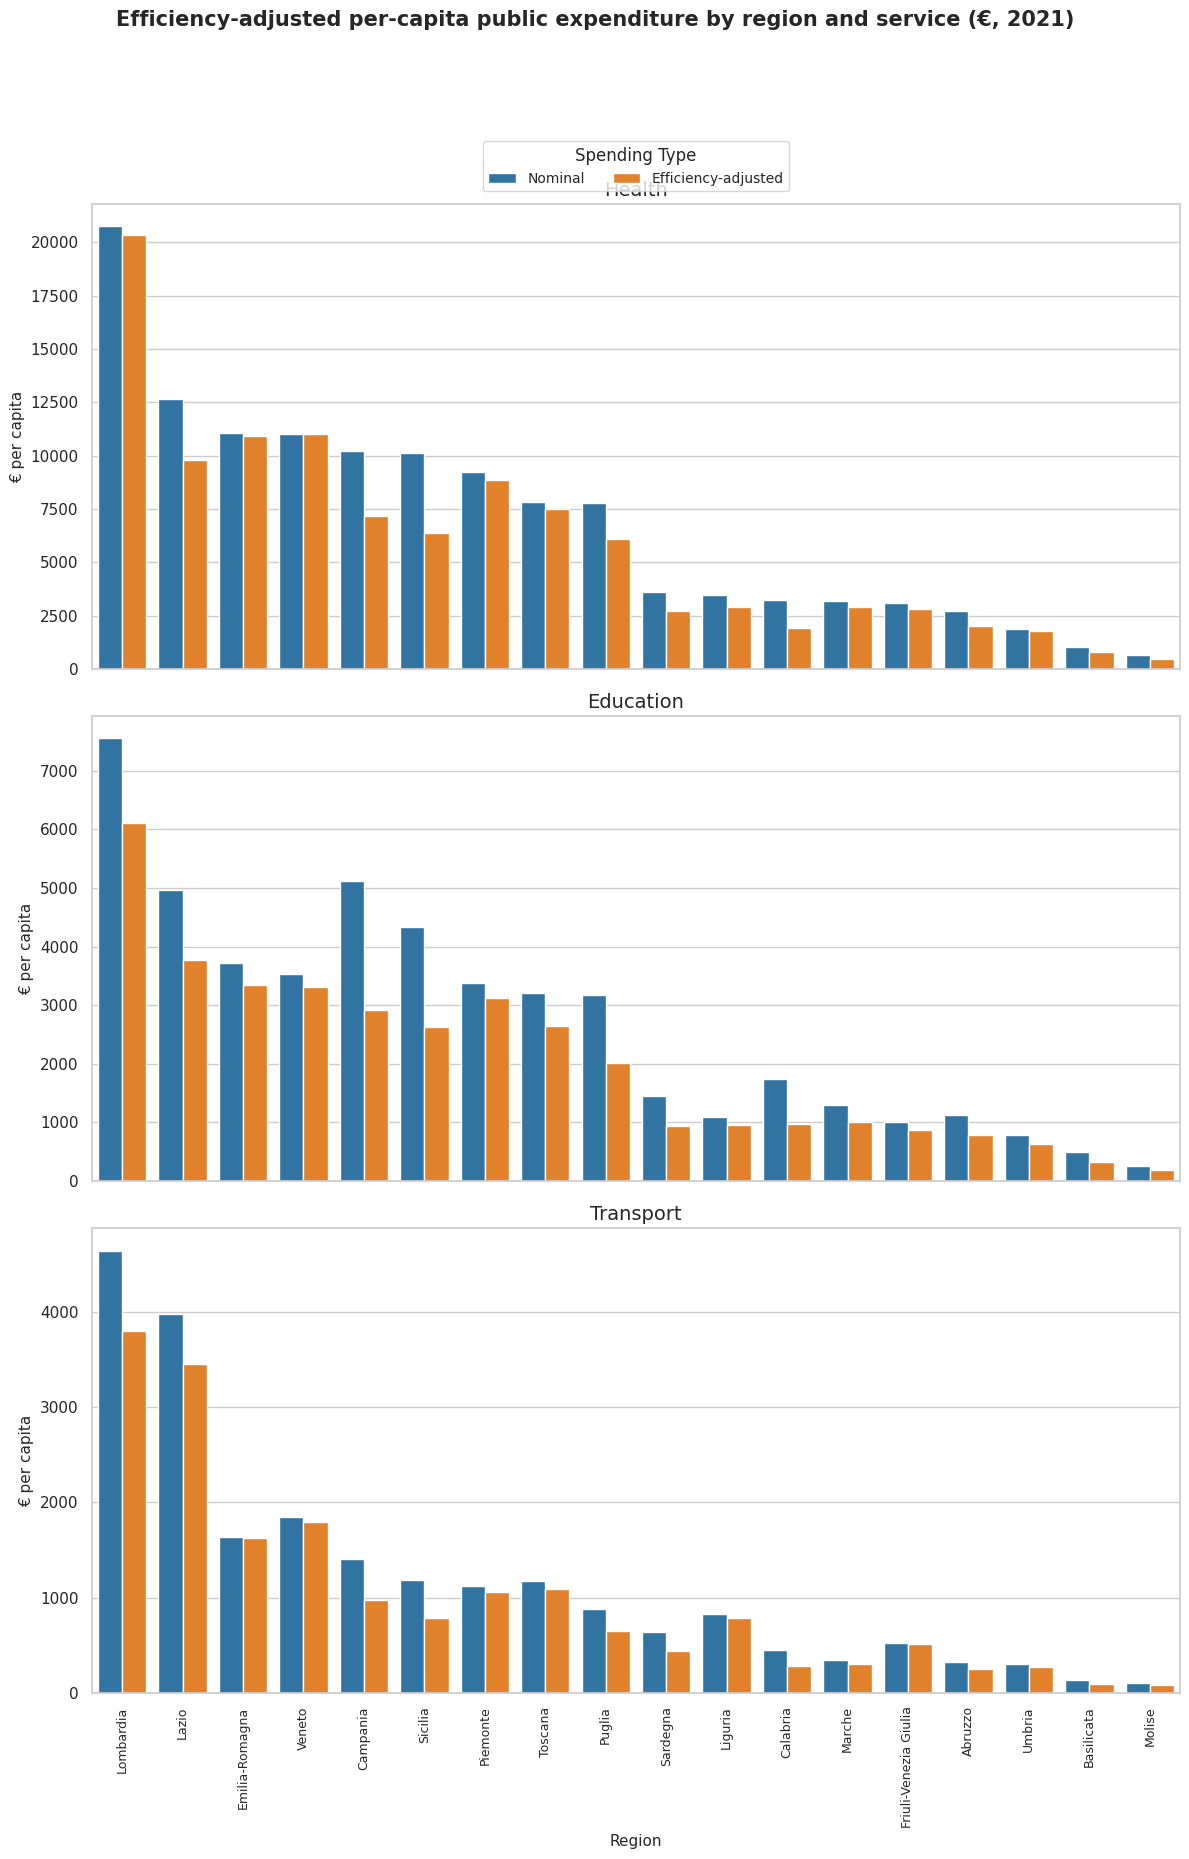


--- Tabella 1: Spesa Pubblica Pro-Capite (Nominale e Aggiustata per Efficienza) ---
service                        istruzione                       sanita                           tpl         
type                  Efficiency-adjusted  Nominal Efficiency-adjusted   Nominal Efficiency-adjusted  Nominal
region_name                                                                                                  
Lombardia                         6115.44  7548.74            20328.94  20756.91             3800.89  4639.32
Lazio                             3766.74  4959.54             9784.59  12654.74             3447.85  3974.61
Emilia-Romagna                    3338.28  3714.43            10947.20  11061.23             1622.32  1642.10
Veneto                            3308.26  3531.79            11023.29  11023.29             1797.69  1842.07
Campania                          2918.31  5123.26             7166.41  10222.68              979.55  1401.77
Sicilia                           2

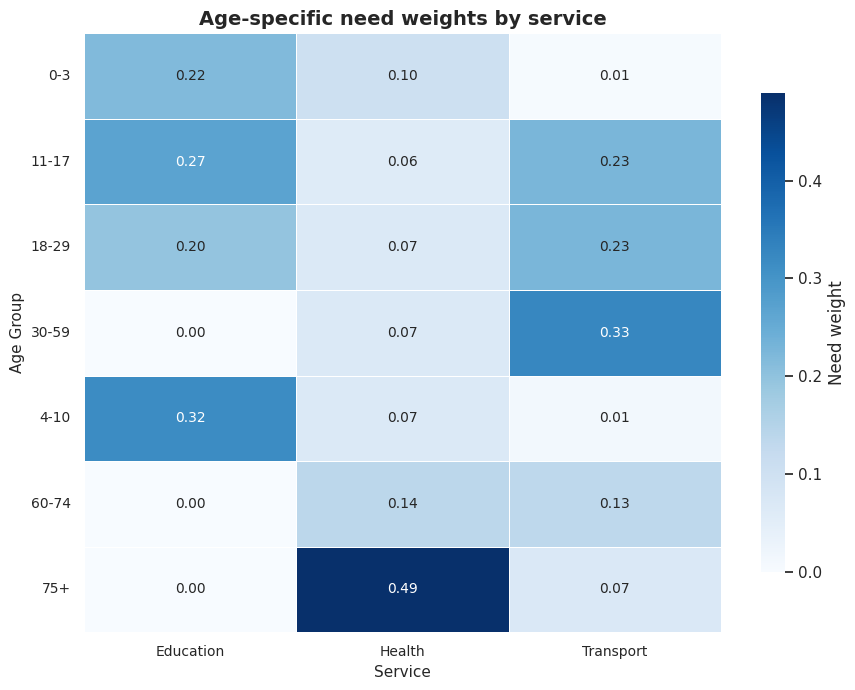


--- Tabella 2: Pesi del Bisogno Aggiustati per Età ---
Service  Health  Education  Transport
Fascia                               
0-3        0.10       0.22       0.00
11-17      0.06       0.27       0.23
18-29      0.07       0.20       0.23
30-59      0.07       0.00       0.33
4-10       0.07       0.32       0.01
60-74      0.14       0.00       0.13
75+        0.49       0.00       0.07


/tmp/ipython-input-3079399720.py:248: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


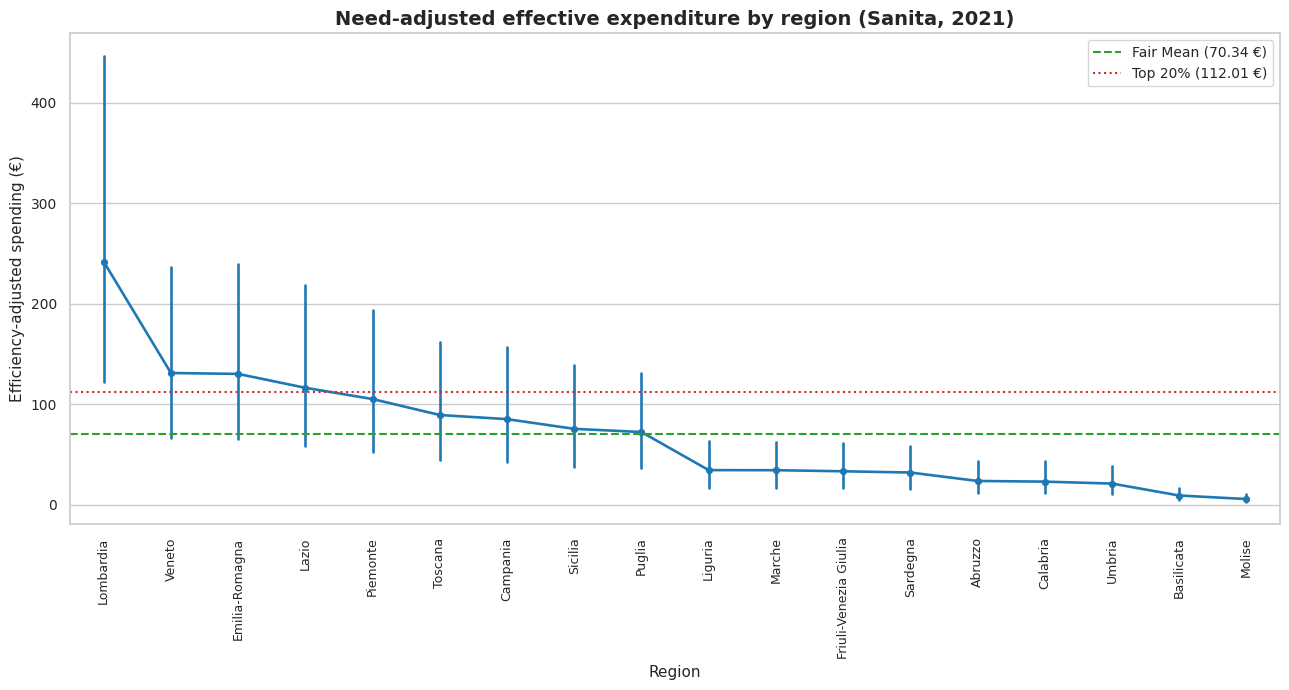


--- Tabella 3: Spesa Aggiustata e Benchmark di Riferimento (Sanita) ---
                              Spesa Media Sanita (€)  Dev. Std. Sanita (€)
Lombardia                                     242.01                262.75
Veneto                                        131.23                142.47
Emilia-Romagna                                130.32                141.49
Lazio                                         116.48                126.46
Piemonte                                      105.31                114.33
Toscana                                        89.42                 97.08
Campania                                       85.31                 92.62
Sicilia                                        75.65                 82.14
Puglia                                         72.48                 78.69
Liguria                                        34.58                 37.55
Marche                                         34.50                 37.45
Friuli-Venezia Giulia      

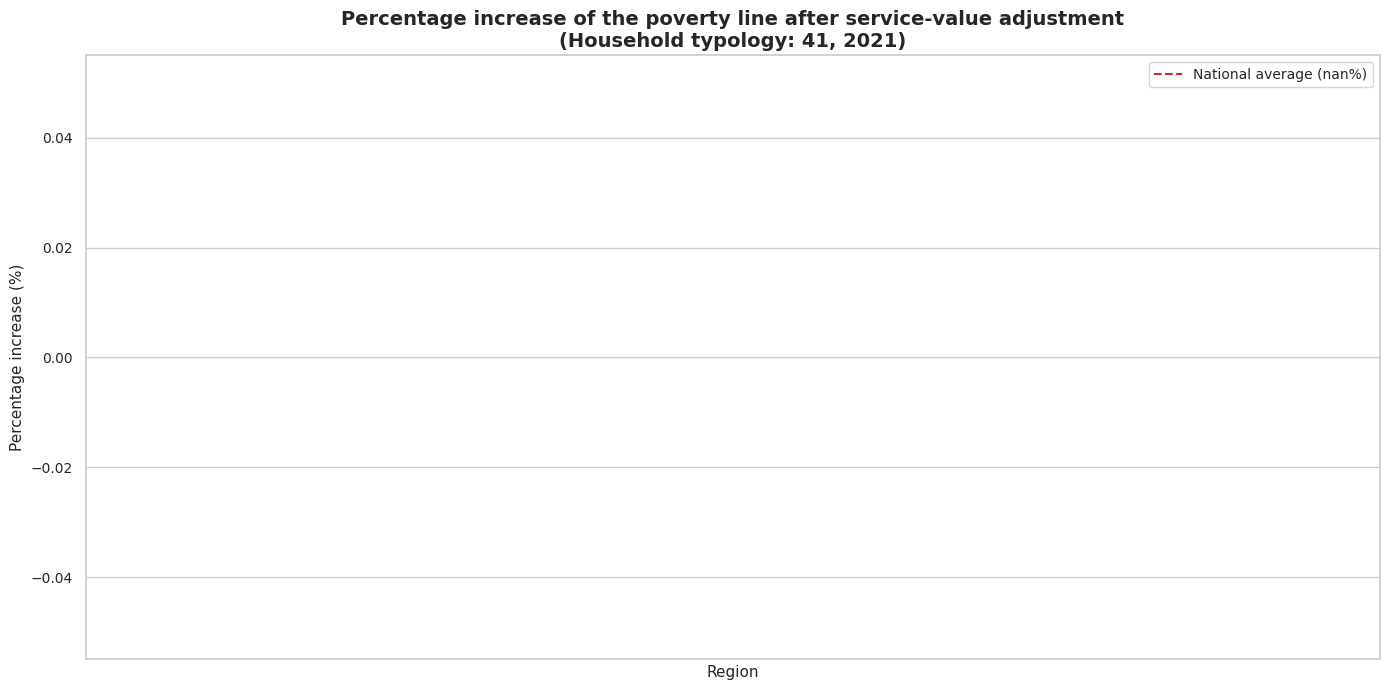


--- Tabella 4: Estensione Soglia di Povertà e Variazioni Regionali ---
                            Soglia ISTAT Originale (€)  Soglia Estesa (€)  Aumento Percentuale (%)  Aumento Soglia (€)
Benchmark: Media Nazionale                          --                 --                       --                  --


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Settaggio Pandas per visualizzare più righe/colonne
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set style for all plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# --- Helper: Map region ID to region name ---
# La mappa deve essere definita prima dell'esecuzione se usata
region_mapping = {
    "Piemonte": 1,
    "Valle d'Aosta": 2,
    "Valle d\"Aosta / Vallée d\"Aoste": 2,  # varianti nel dataset
    "Lombardia": 3,
    "Trentino-Alto Adige": 4,
    "Trentino Alto Adige / Südtirol": 4,
    "Provincia Autonoma di Trento": 4,
    "Provincia Autonoma di Bolzano": 4,
    "Veneto": 5,
    "Friuli Venezia Giulia": 6,
    "Friuli-Venezia Giulia": 6,
    "Liguria": 7,
    "Emilia Romagna": 8,
    "Emilia-Romagna": 8,
    "Toscana": 9,
    "Umbria": 10,
    "Marche": 11,
    "Lazio": 12,
    "Abruzzo": 13,
    "Molise": 14,
    "Campania": 15,
    "Puglia": 16,
    "Basilicata": 17,
    "Calabria": 18,
    "Sicilia": 19,
    "Sardegna": 20,
}
region_id_to_name = {v: k for k, v in region_mapping.items()}

# ============================================
# Step 1 — Efficiency-adjusted per-capita expenditure
# ============================================
def plot_efficiency_adjusted_spending(spending_wide_df, year=2021, region_id_to_name=None):
    """Plots efficiency-adjusted public spending and outputs the underlying data table."""

    # 1. Preparazione Dati
    if region_id_to_name is None:
        print("Errore: Manca 'region_id_to_name'. Utilizzando solo ID regione.")
        # Fallback: use reg_id if mapping is missing or incomplete
        # Create a temporary mapping from available reg_ids to string representation
        temp_map = {id: str(id) for id in spending_wide_df["reg_id"].unique()}
        spending_wide_df["region_name"] = spending_wide_df["reg_id"].map(temp_map)

    else:
        # Use the provided mapping
        spending_wide_df["region_name"] = spending_wide_df["reg_id"].map(region_id_to_name)
        # Handle regions not in the provided map
        if spending_wide_df["region_name"].isnull().any():
             print("Warning: Some region_ids not found in region_id_to_name mapping.")
             # Fill missing region names with reg_id string representation
             spending_wide_df["region_name"] = spending_wide_df.apply(
                 lambda row: row["region_name"] if pd.notnull(row["region_name"]) else str(row["reg_id"]),
                 axis=1
             )


    year_df = spending_wide_df[spending_wide_df["year"] == year].copy()

    melted_df = year_df.melt(
        id_vars=["reg_id", "region_name"],
        value_vars=[
            "spesa_reale_sanita", "spesa_eff_sanita",
            "spesa_reale_istruzione", "spesa_eff_istruzione",
            "spesa_reale_tpl", "spesa_eff_tpl"
        ],
        var_name="metric",
        value_name="spending"
    )
    melted_df["type"] = melted_df["metric"].apply(
        lambda x: "Nominal" if "reale" in x else "Efficiency-adjusted"
    )
    melted_df["service"] = melted_df["metric"].apply(
        lambda x: x.split("_")[-1]
    )

    # Ordine basato sulla spesa nominale in Sanità
    # Ensure that region_name is not NaN before sorting
    order = year_df.dropna(subset=['region_name']).groupby("region_name")["spesa_reale_sanita"].mean().sort_values(ascending=False).index


    # 2. Plotting
    fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)
    service_mapping = {
        "sanita": "Health",
        "istruzione": "Education",
        "tpl": "Transport"
    }
    services = ["sanita", "istruzione", "tpl"]

    for i, service in enumerate(services):
        ax = axes[i]

        # Filter melted_df to ensure region_name is not NaN for plotting
        plot_data = melted_df[(melted_df["service"] == service) & melted_df["region_name"].notna()]

        sns.barplot(
            data=plot_data,
            x="region_name", y="spending", hue="type",
            order=order, ax=ax, palette=["#1f77b4", "#ff7f0e"]
        )

        ax.set_title(f"{service_mapping[service]}", fontsize=14)
        ax.set_ylabel("€ per capita", fontsize=11)
        ax.tick_params(axis="x", rotation=90, labelsize=9)

        if i < 2:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Region", fontsize=11)

        ax.legend().set_visible(False)

    axes[0].legend(
        loc="upper center",
        bbox_to_anchor=(0.5, 1.15),
        ncol=2,
        title="Spending Type",
        fontsize=10
    )

    plt.suptitle(
        "Efficiency-adjusted per-capita public expenditure by region and service (€, 2021)",
        y=1.03, fontsize=15, weight='bold'
    )

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    # 3. Generazione Tabella Completa
    # Ensure region_name is not NaN before pivoting
    table_df = melted_df[melted_df["region_name"].notna()].pivot_table(
        index=["region_name"],
        columns=["service", "type"],
        values="spending",
        aggfunc="mean"
    )
    column_order = [
        ('sanita', 'Nominal'), ('sanita', 'Efficiency-adjusted'),
        ('istruzione', 'Nominal'), ('istruzione', 'Efficiency-adjusted'),
        ('tpl', 'Nominal'), ('tpl', 'Efficiency-adjusted')
    ]
    # Reindex and sort after handling potential missing region_names
    table_df = table_df.reindex(order).round(2)

    print("\n--- Tabella 1: Spesa Pubblica Pro-Capite (Nominale e Aggiustata per Efficienza) ---")
    print(table_df.to_string())


# ============================================
# Step 2 — Need-weighted adjustment by demographic structure
# ============================================
def plot_need_weights(age_need_df):
    """Plots heatmap of age-specific need weights and outputs the underlying data table."""
    # 1. Preparazione Dati
    heatmap_data = age_need_df.melt(
        id_vars=["Fascia"],
        value_vars=["peso_san", "peso_istr", "peso_tpl"],
        var_name="Service",
        value_name="Weight"
    )
    heatmap_data["Service"] = heatmap_data["Service"].replace({
        "peso_san": "Health",
        "peso_istr": "Education",
        "peso_tpl": "Transport"
    })
    heatmap_pivot = heatmap_data.pivot(
        index="Fascia",
        columns="Service",
        values="Weight"
    )

    # 2. Plotting
    plt.figure(figsize=(9, 7))
    sns.heatmap(
        heatmap_pivot,
        annot=True,
        fmt=".2f",
        cmap="Blues",
        linewidths=.5,
        cbar_kws={"label": "Need weight", "shrink": 0.8}
    )
    plt.title("Age-specific need weights by service", fontsize=14, weight='bold')
    plt.xlabel("Service", fontsize=11)
    plt.ylabel("Age Group", fontsize=11)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)

    plt.tight_layout()
    plt.show()

    # 3. Generazione Tabella Completa
    print("\n--- Tabella 2: Pesi del Bisogno Aggiustati per Età ---")
    table_df = heatmap_pivot[['Health', 'Education', 'Transport']].round(2)
    print(table_df.to_string())

# ============================================
# Step 3 — Computation of fair benchmarks (CORRETTO per Varianza)
# ============================================
def plot_benchmark_comparison(per_capita_df, year=2021, service="sanita", region_id_to_name=None):
    """Plots comparison of need-adjusted effective expenditure against benchmarks and outputs the underlying data table."""

    # 1. Preparazione Dati
    if region_id_to_name is None:
        print("Errore: Manca 'region_id_to_name'. Utilizzando solo ID regione.")
        per_capita_df["region_name"] = per_capita_df["reg_id"]
    else:
        per_capita_df["region_name"] = per_capita_df["reg_id"].map(region_id_to_name)

    year_df = per_capita_df[per_capita_df["year"] == year].copy()
    col = f"spesa_procapite_eff_{service}"
    service_title = service.capitalize() if service != 'tpl' else 'TPL'

    # *** CORREZIONE CRUCIALE: Calcola la MEDIA e la DEVIAZIONE STANDARD per Regione ***
    # Ensure region_name is not NaN before grouping
    regional_stats = year_df.dropna(subset=['region_name']).groupby("region_name")[col].agg(['mean', 'std'])

    # Calcolo dei valori di dispersione/benchmark sulla media regionale (Media)
    fair_mean = regional_stats['mean'].mean()
    top20 = regional_stats['mean'].quantile(0.8)

    # Ordine basato sul valore della spesa effettiva (Media)
    regional_stats = regional_stats.sort_values(by='mean', ascending=False)
    order = regional_stats.index

    # 2. Plotting (usa il DataFrame originale per il pointplot che gestisce la media)
    plt.figure(figsize=(13, 7))
    # Filter year_df to ensure region_name is not NaN for plotting
    plot_data = year_df[year_df["region_name"].notna()]
    sns.pointplot(
        data=plot_data, x="region_name", y=col,
        order=order, color="#1f77b4", scale=0.7
    )

    # Linee di benchmark
    plt.axhline(fair_mean, color="#2ca02c", linestyle="--", linewidth=1.5, label=f"Fair Mean ({fair_mean:.2f} €)")
    plt.axhline(top20, color="#d62728", linestyle=":", linewidth=1.5, label=f"Top 20% ({top20:.2f} €)")

    # Stile
    plt.title(
        f"Need-adjusted effective expenditure by region ({service_title}, {year})",
        fontsize=14, weight='bold'
    )
    plt.xlabel("Region", fontsize=11)
    plt.ylabel("Efficiency-adjusted spending (€)", fontsize=11)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(fontsize=10)

    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3. Generazione Tabella Completa
    table_df = regional_stats.round(2)
    # Rinomina le colonne in modo chiaro
    table_df.columns = [f"Spesa Media {service_title} (€)", f"Dev. Std. {service_title} (€)"]

    # Crea un DataFrame per i benchmark (per l'unione). La Dev. Std. è NaN.
    benchmark_data = {
        "Benchmark: Top 20%": [top20, np.nan],
        "Benchmark: Fair Mean (Media)": [fair_mean, np.nan],
    }
    # Crea il DataFrame con la stessa struttura (colonne) della tabella regionale
    benchmark_series = pd.DataFrame(
        benchmark_data,
        index=[f"Spesa Media {service_title} (€)", f"Dev. Std. {service_title} (€)"]
    ).T.round(2)

    # Concatena i dati regionali con i benchmark
    table_complete = pd.concat([table_df, benchmark_series])

    print(f"\n--- Tabella 3: Spesa Aggiustata e Benchmark di Riferimento ({service_title}) ---")
    print(table_complete.to_string(na_rep='--')) # na_rep='--' per visualizzare i NaN in modo più pulito


# ============================================
# Step 4 — Extension of the poverty line
# ============================================
def plot_poverty_line_extension(families_df, year=2021, typology=41):
    """Plots the percentage increase of the poverty line after service adjustment and outputs the underlying data table."""

    # 1. Preparazione Dati
    plot_df = families_df[
        (families_df["year"] == year) &
        (families_df["codice_tipologia_famiglia"] == typology)
    ].copy()

    plot_df["region_name"] = plot_df["reg"].map(lambda x: x.split("/")[0].strip())

    # Calcola soglie e aumento percentuale
    plot_df["pct_increase"] = (
        (plot_df["soglia_estesa"] - plot_df["OBS_VALUE"]) / plot_df["OBS_VALUE"] * 100
    )
    plot_df["delta_soglia_euro"] = plot_df["soglia_estesa"] - plot_df["OBS_VALUE"]

    # Calcola la media per regione e la media nazionale
    # Ensure region_name is not NaN before grouping
    region_means = plot_df.dropna(subset=['region_name']).groupby("region_name")[["OBS_VALUE", "soglia_estesa", "pct_increase", "delta_soglia_euro"]].mean()

    # *** Riordina il DataFrame per l'ordinamento del grafico ***
    region_means = region_means.sort_values(by="pct_increase", ascending=False)

    national_avg = region_means["pct_increase"].mean()

    # 2. Plotting
    plt.figure(figsize=(14, 7))
    plt.bar(
        x=np.arange(len(region_means)),
        height=region_means["pct_increase"],
        color="#1f77b4",
        width=0.8
    )

    # Aggiungi etichette x (nomi delle regioni)
    plt.xticks(np.arange(len(region_means)), region_means.index, rotation=90, fontsize=9)

    # Aggiungi linea della media nazionale
    plt.axhline(national_avg, color="#d62728", linestyle="--", linewidth=1.5, label=f"National average ({national_avg:.1f}%)")

    # Stile
    plt.title(
        f"Percentage increase of the poverty line after service-value adjustment\n"
        f"(Household typology: {typology}, {year})",
        fontsize=14, weight='bold'
    )
    plt.xlabel("Region", fontsize=11)
    plt.ylabel("Percentage increase (%)", fontsize=11)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.legend(loc='upper right', fontsize=10)
    plt.show()

    # 3. Generazione Tabella Completa
    # Ensure region_name is not NaN before rounding
    table_df = region_means.round(2)

    # Aggiunge le righe per i benchmark al DataFrame
    benchmark_data = {
        "OBS_VALUE": np.nan,
        "soglia_estesa": np.nan,
        "pct_increase": national_avg,
        "delta_soglia_euro": np.nan
    }
    benchmark_series = pd.Series(benchmark_data, name="Benchmark: Media Nazionale").to_frame().T

    # Unisce la tabella dei dati regionali con i benchmark e rinomina colonne
    table_complete = pd.concat([table_df, benchmark_series])
    table_complete.columns = [
        "Soglia ISTAT Originale (€)",
        "Soglia Estesa (€)",
        "Aumento Percentuale (%)",
        "Aumento Soglia (€)"
    ]

    print("\n--- Tabella 4: Estensione Soglia di Povertà e Variazioni Regionali ---")
    print(table_complete.to_string(na_rep='--'))


# ============================================
# Execute all plots
# ============================================

# Qui andranno le chiamate alle funzioni
plot_efficiency_adjusted_spending(df_spesa_wide, region_id_to_name=region_id_to_name)
plot_need_weights(age_need_df)
plot_benchmark_comparison(df_procapite, region_id_to_name=region_id_to_name)
plot_poverty_line_extension(df_famiglie, typology=41) # Esempio con tipologia 41

/tmp/ipython-input-3852284869.py:53: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-3852284869.py:53: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/tmp/ipython-input-3852284869.py:53: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(


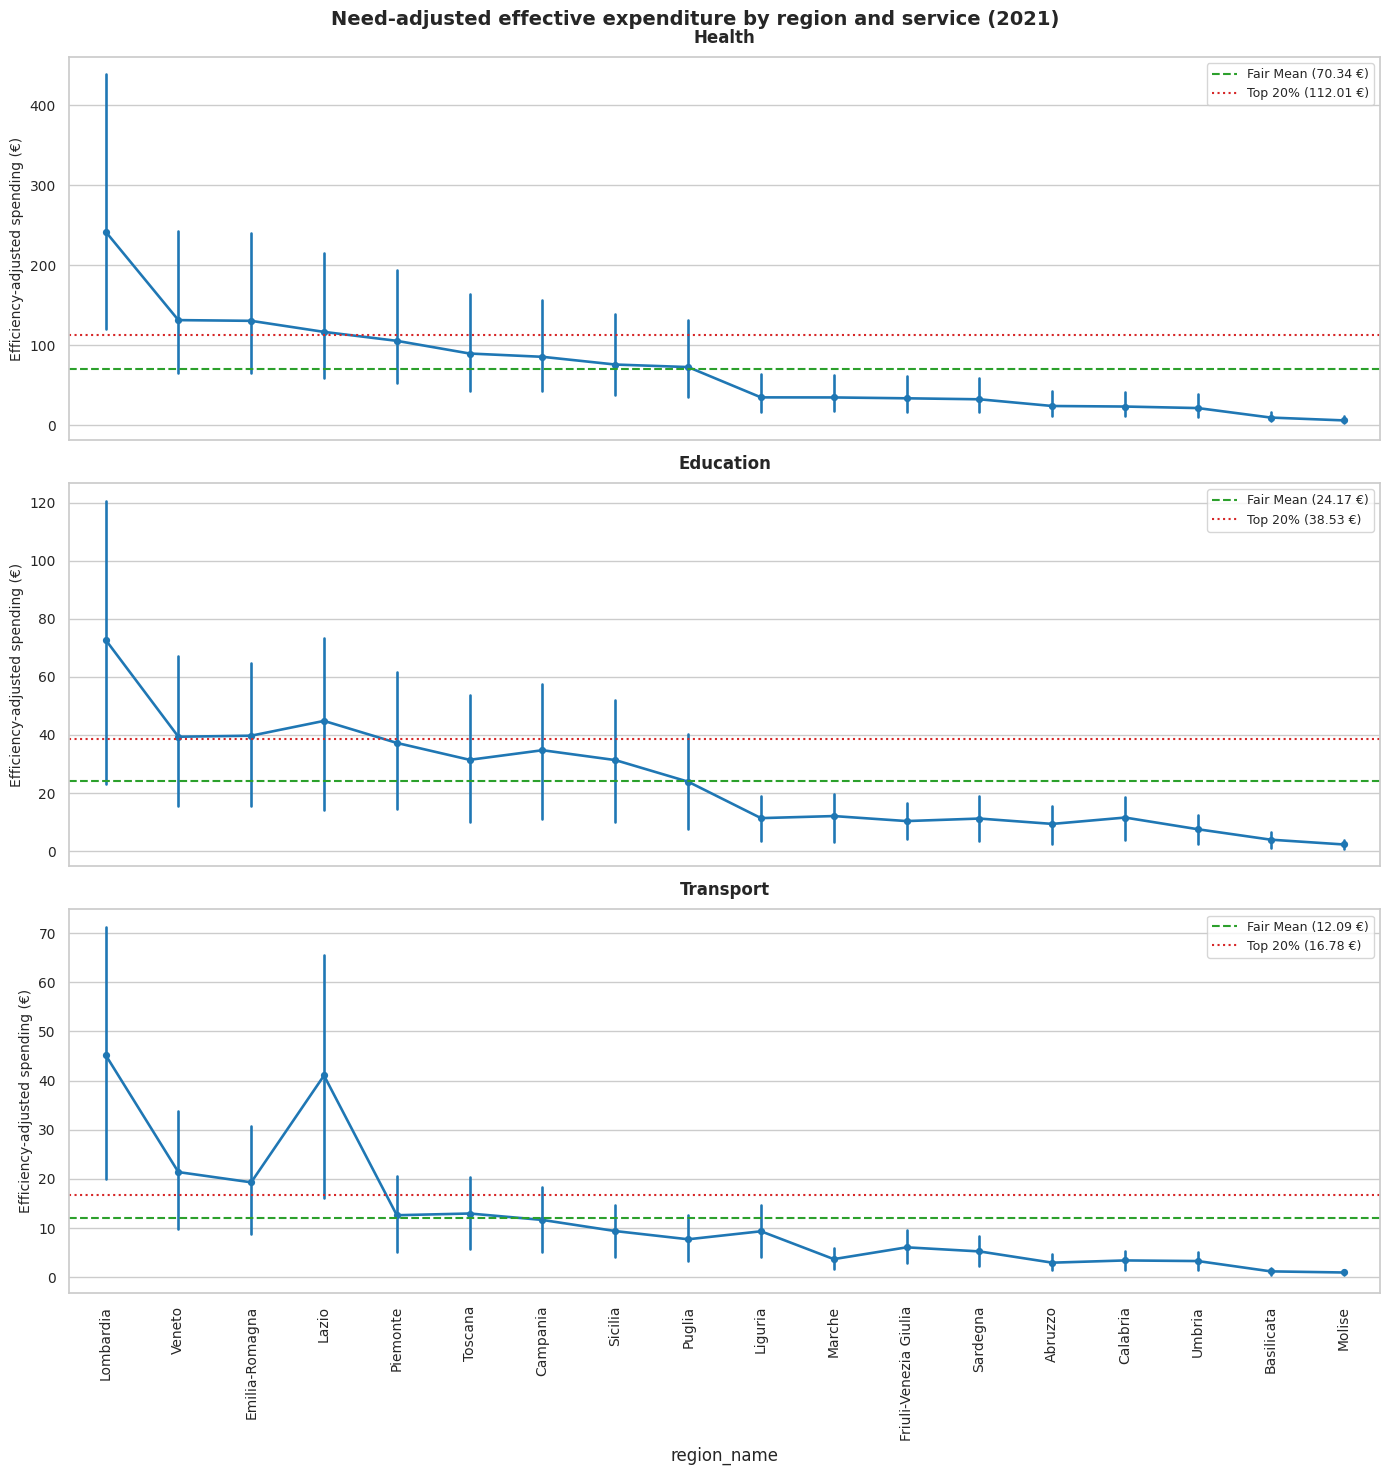


COMBINED TABLE: Regional Spending and Benchmarks for All Services
                       Mean Health (€)  Std Dev Health (€)  Mean Education (€)  Std Dev Education (€)  Mean Transport (€)  Std Dev Transport (€)
Abruzzo                          23.79               25.83                9.36                   9.11                2.97                   2.53
Basilicata                        9.32               10.11                3.93                   3.82                1.20                   1.02
Benchmark: Fair Mean             70.34                  --               24.17                     --               12.09                     --
Benchmark: Top 20%              112.01                  --               38.53                     --               16.78                     --
Calabria                         23.12               25.10               11.55                  11.24                3.42                   2.92
Campania                         85.31               92.62     

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display

# Set style for all plots
sns.set_style("whitegrid")
plt.rcParams["font.size"] = 10

def plot_all_benchmarks_comparison(per_capita_df, year=2021, region_id_to_name=None):
    """Plots comparison of need-adjusted effective expenditure for all services in one figure."""
    services = ["sanita", "istruzione", "tpl"]
    service_titles = {
        "sanita": "Health",
        "istruzione": "Education",
        "tpl": "Transport"
    }

    # Preparazione dati
    if region_id_to_name is None:
        print("Warning: Missing 'region_id_to_name'. Using region IDs.")
        per_capita_df["region_name"] = per_capita_df["reg_id"]
    else:
        per_capita_df["region_name"] = per_capita_df["reg_id"].map(region_id_to_name)

    year_df = per_capita_df[per_capita_df["year"] == year].copy()

    # Crea figura con 3 subplot verticali (più compatti)
    fig, axes = plt.subplots(3, 1, figsize=(14, 15), sharex=True)  # Ridotto altezza da 18 a 15
    fig.suptitle(f"Need-adjusted effective expenditure by region and service ({year})",
                fontsize=14, weight='bold', y=0.98)  # Abbassato il titolo

    # Dizionario per salvare i dati delle tabelle
    tables_data = {}

    for i, service in enumerate(services):
        ax = axes[i]
        col = f"spesa_procapite_eff_{service}"
        service_title = service_titles[service]

        # Calcola media e deviazione standard per regione
        regional_stats = year_df.groupby("region_name")[col].agg(['mean', 'std'])

        # Calcolo dei benchmark
        fair_mean = regional_stats['mean'].mean()
        top20 = regional_stats['mean'].quantile(0.8)

        # Ordine basato sulla spesa media
        order = regional_stats.sort_values(by='mean', ascending=False).index

        # Plotting
        sns.pointplot(
            data=year_df, x="region_name", y=col,
            order=order, color="#1f77b4", ax=ax, scale=0.7
        )

        # Linee di benchmark
        ax.axhline(fair_mean, color="#2ca02c", linestyle="--", linewidth=1.5,
                  label=f"Fair Mean ({fair_mean:.2f} €)")
        ax.axhline(top20, color="#d62728", linestyle=":", linewidth=1.5,
                  label=f"Top 20% ({top20:.2f} €)")

        # Stile migliorato
        ax.set_title(f"{service_title}", fontsize=12, weight='bold', pad=10)
        ax.set_ylabel("Efficiency-adjusted spending (€)", fontsize=10)
        ax.tick_params(axis='x', rotation=90, labelsize=10)  # Ingrandite etichette x
        ax.tick_params(axis='y', labelsize=10)
        ax.legend(loc='upper right', fontsize=9)

        # Salva i dati per la tabella
        table_df = regional_stats.round(2)
        table_df.columns = [f"Mean {service_title} (€)", f"Std Dev {service_title} (€)"]

        benchmark_data = {
            "Benchmark: Top 20%": [top20, np.nan],
            "Benchmark: Fair Mean": [fair_mean, np.nan],
        }
        benchmark_series = pd.DataFrame(
            benchmark_data,
            index=[f"Mean {service_title} (€)", f"Std Dev {service_title} (€)"]
        ).T.round(2)

        tables_data[service] = pd.concat([table_df, benchmark_series])

    # Aggiusta layout per portare i grafici più in basso
    plt.subplots_adjust(hspace=0.3, top=0.92, bottom=0.1)  # Regolato spacing
    plt.tight_layout()
    plt.show()

    # Crea tabella riassuntiva unificata
    combined_table = pd.DataFrame()

    for service in services:
        service_title = service_titles[service]
        temp_df = tables_data[service].copy()

        # Rinomina le colonne per includere il servizio
        temp_df.columns = [
            f"Mean {service_title} (€)",
            f"Std Dev {service_title} (€)"
        ]

        if combined_table.empty:
            combined_table = temp_df
        else:
            combined_table = pd.merge(
                combined_table,
                temp_df,
                left_index=True,
                right_index=True,
                how='outer'
            )

    print("\n" + "="*100)
    print("COMBINED TABLE: Regional Spending and Benchmarks for All Services")
    print("="*100)
    print(combined_table.to_string(na_rep='--'))
    print("="*100 + "\n")

    return combined_table

    # Crea tabella riassuntiva unificata
    combined_table = pd.DataFrame()

    for service in services:
        service_title = service_titles[service]
        temp_df = tables_data[service].copy()

        # Rinomina le colonne per includere il servizio
        temp_df.columns = [
            f"Mean {service_title} (€)",
            f"Std Dev {service_title} (€)"
        ]

        if combined_table.empty:
            combined_table = temp_df
        else:
            combined_table = pd.merge(
                combined_table,
                temp_df,
                left_index=True,
                right_index=True,
                how='outer'
            )

    print("\n" + "="*100)
    print("COMBINED TABLE: Regional Spending and Benchmarks for All Services")
    print("="*100)
    print(combined_table.to_string(na_rep='--'))
    print("="*100 + "\n")

    return combined_table

# Esegui la funzione
combined_results = plot_all_benchmarks_comparison(df_procapite, region_id_to_name=region_id_to_name)


In [ ]:
# Verifica le colonne di df_gap_wide
print("Colonne in df_gap_wide:", df_gap_wide.columns.tolist())

# Verifica i valori di gap_eff_top20_istruzione_* in df_gap_wide
for fascia in fasce_rilevanti:
    col = f"gap_eff_top20_istruzione_{fascia}"
    if col in df_gap_wide.columns:
        print(f"Valori per {col}:", df_gap_wide[col].dropna().head())
    else:
        print(f"Colonna {col} non trovata!")

# Verifica il merge tra df_famiglie e df_gap_wide
print("Colonne in df_famiglie dopo il merge:", df_famiglie.columns.tolist())


Colonne in df_gap_wide: ['year', 'reg_id', 'gap_eff_top20_istruzione_0-3', 'gap_eff_top20_istruzione_11-17', 'gap_eff_top20_istruzione_18-29', 'gap_eff_top20_istruzione_30-59', 'gap_eff_top20_istruzione_4-10', 'gap_eff_top20_istruzione_60-74', 'gap_eff_top20_istruzione_75+', 'gap_eff_top20_sanita_0-3', 'gap_eff_top20_sanita_11-17', 'gap_eff_top20_sanita_18-29', 'gap_eff_top20_sanita_30-59', 'gap_eff_top20_sanita_4-10', 'gap_eff_top20_sanita_60-74', 'gap_eff_top20_sanita_75+', 'gap_eff_top20_tpl_0-3', 'gap_eff_top20_tpl_11-17', 'gap_eff_top20_tpl_18-29', 'gap_eff_top20_tpl_30-59', 'gap_eff_top20_tpl_4-10', 'gap_eff_top20_tpl_60-74', 'gap_eff_top20_tpl_75+']
Valori per gap_eff_top20_istruzione_0-3: 0    15.144718
1     0.000000
2    11.589466
3    50.002197
4    48.387375
Name: gap_eff_top20_istruzione_0-3, dtype: float64
Valori per gap_eff_top20_istruzione_4-10: 0    21.875704
1     0.000000
2    16.740340
3    72.225395
4    69.892875
Name: gap_eff_top20_istruzione_4-10, dtype: float64

In [ ]:
print(df_famiglie[
    (df_famiglie["codice_tipologia_famiglia"] == 41) &
    (df_famiglie["year"] == 2021)
][["reg", "n_0-3", "n_4-10", "n_11-17", "n_18-29"]].head(10))


Empty DataFrame
Columns: [reg, n_0-3, n_4-10, n_11-17, n_18-29]
Index: []



TABLE: Average extended threshold composition by region (All household typologies, 2021)
                       Health (€)  Education (€)  Transport (€)  Total (€)
region_name                                                               
Molise                     377.09          88.74         154.31     620.14
Basilicata                 368.19          85.63         153.17     606.98
Umbria                     338.16          78.83         142.65     559.64
Abruzzo                    331.61          75.35         144.30     551.26
Calabria                   333.31          71.21         142.02     546.53
Marche                     304.55          70.24         140.68     515.47
Sardegna                   310.39          71.86         132.82     515.07
Friuli-Venezia Giulia      307.26          73.50         128.65     509.41
Liguria                    304.33          71.58         112.28     488.19
Puglia                     208.55          47.85         120.44     376.84
Sicilia   

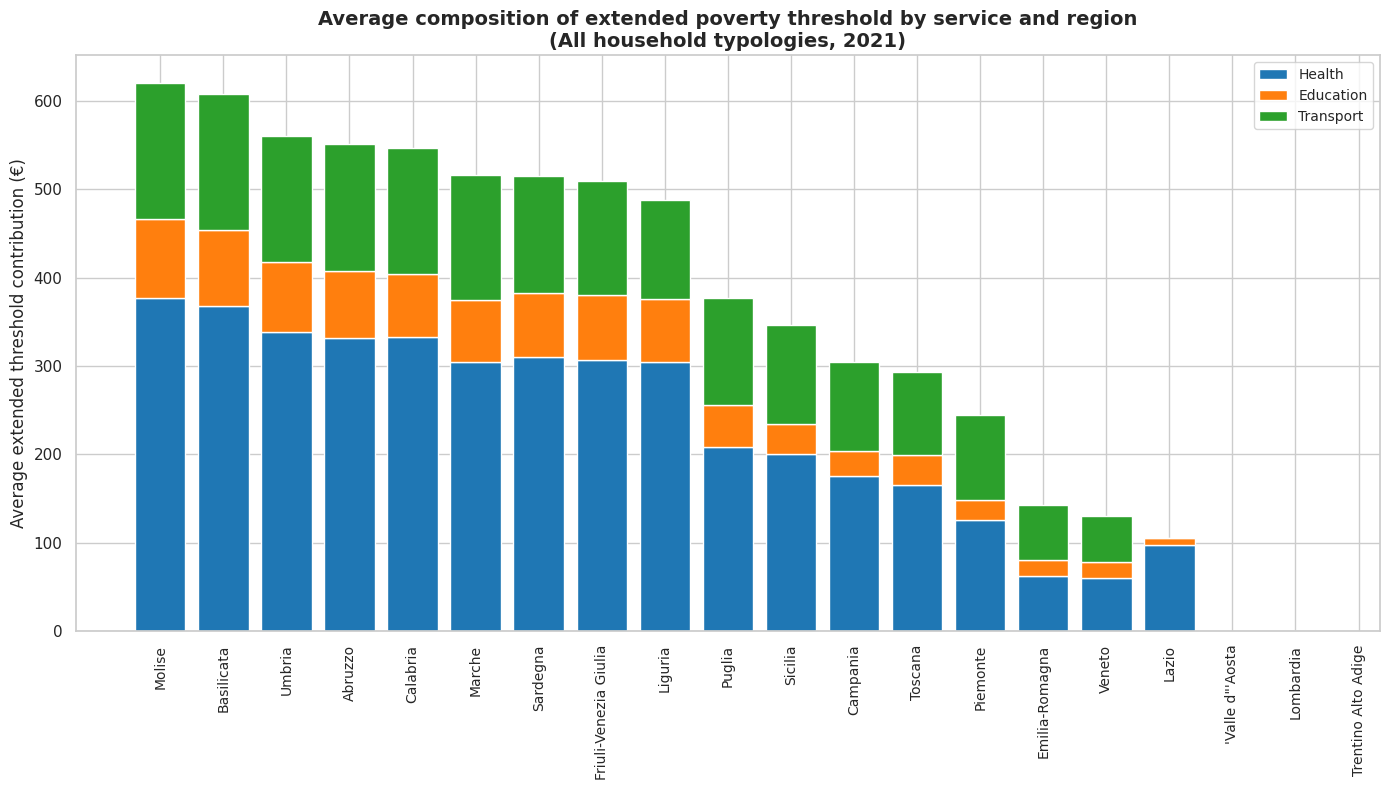

In [ ]:
def plot_extended_threshold_composition_by_age(families_df, year=2021):
    """
    Crea un bar plot stackato che mostra la composizione media dell'aumento della soglia di povertà
    per ogni regione e fascia d'età, suddivisa per i tre servizi (sanità, istruzione, trasporti).
    """
    # Filtra per anno
    plot_df = families_df[(families_df["year"] == year)].copy()
    plot_df["region_name"] = plot_df["reg"].map(lambda x: x.split("/")[0].strip())

    # Calcola la parte estesa per ogni servizio
    plot_df["health_contribution"] = plot_df["gap_familiare_eff_top20_sanita"]
    plot_df["education_contribution"] = plot_df["gap_familiare_eff_top20_istruzione"]
    plot_df["transport_contribution"] = plot_df["gap_familiare_eff_top20_tpl"]

    # Aggiungi le fasce d'età
    fasce_eta = ["0-3", "4-10", "11-17", "18-29", "30-59", "60-74", "75+"]

    # Calcola la media per ogni fascia d'età e regione
    age_region_sums = {}
    for fascia in fasce_eta:
        age_region_sums[fascia] = plot_df.groupby("region_name")[
            ["health_contribution", "education_contribution", "transport_contribution"]
        ].mean()

    # Calcola la media totale per ogni regione
    regional_avg = plot_df.groupby("region_name")[
        ["health_contribution", "education_contribution", "transport_contribution"]
    ].mean()

    # Ordina le regioni per il contributo totale medio
    regional_avg["total"] = regional_avg.sum(axis=1)
    regional_avg = regional_avg.sort_values("total", ascending=False)
    order = regional_avg.index

    # Crea il plot stackato
    plt.figure(figsize=(14, 8))

    # Colori distinti per ogni servizio
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blu, arancione, verde

    # Barre stackate
    bottom = np.zeros(len(order))
    for i, service in enumerate(["health_contribution", "education_contribution", "transport_contribution"]):
        values = regional_avg[service]
        plt.bar(
            np.arange(len(order)),
            values,
            bottom=bottom,
            color=colors[i],
            label=["Health", "Education", "Transport"][i],
            width=0.8
        )
        bottom += values

    # Etichette e stile
    plt.xticks(np.arange(len(order)), order, rotation=90, fontsize=10)
    plt.ylabel("Average extended threshold contribution (€)", fontsize=12)
    plt.title(
        f"Average composition of extended poverty threshold by service and region\n"
        f"(All household typologies, {year})",
        fontsize=14, weight='bold'
    )

    # Legenda
    plt.legend(loc='upper right', fontsize=10)

    # Aggiusta layout
    plt.tight_layout()

    # Crea tabella con i valori medi
    table = regional_avg.drop(columns="total").round(2)
    table.columns = ["Health (€)", "Education (€)", "Transport (€)"]
    table["Total (€)"] = regional_avg["total"].round(2)

    print("\n" + "="*100)
    print(f"TABLE: Average extended threshold composition by region (All household typologies, {year})")
    print("="*100)
    print(table.to_string())
    print("="*100 + "\n")

    # Stampa le medie per ogni fascia d'età
    for fascia in fasce_eta:
        print(f"\nAverage contributions for age group {fascia}:")
        print(age_region_sums[fascia].round(2).to_string())

    plt.show()
    return table, age_region_sums

# Esempio di utilizzo:
composition_table_avg, age_region_sums = plot_extended_threshold_composition_by_age(df_famiglie, year=2021)



TABLE: Average extended threshold composition by region (Non-zero education contributions, 2021)
                       Health (€)  Education (€)  Transport (€)  Total (€)
region_name                                                               
Molise                     365.11         117.37         173.37     655.85
Basilicata                 356.50         113.25         172.09     641.83
Umbria                     327.42         104.26         160.27     591.96
Abruzzo                    321.08          99.66         162.12     582.86
Calabria                   322.72          94.18         159.56     576.46
Marche                     294.88          92.90         158.06     545.84
Sardegna                   300.54          95.04         149.23     544.80
Friuli-Venezia Giulia      297.50          97.21         144.55     539.26
Liguria                    294.67          94.67         126.15     515.49
Puglia                     201.93          63.29         135.32     400.54
Si

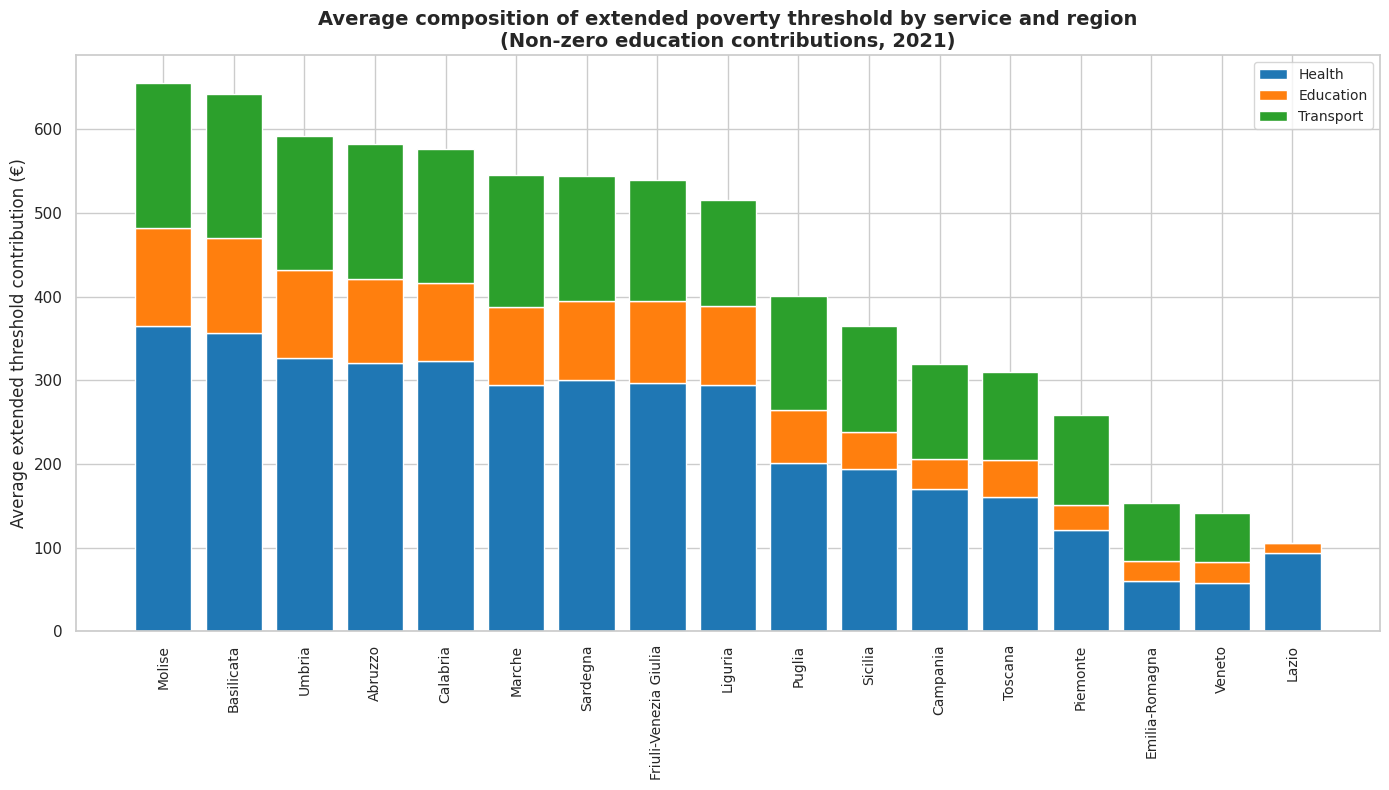

In [ ]:
def plot_extended_threshold_composition_non_zero_education(families_df, year=2021):
    """
    Crea un bar plot stackato che mostra la composizione media dell'aumento della soglia di povertà
    per ogni regione, considerando solo le fasce d'età con almeno un contributo non nullo per l'istruzione.
    """
    # Filtra per anno
    plot_df = families_df[(families_df["year"] == year)].copy()
    plot_df["region_name"] = plot_df["reg"].map(lambda x: x.split("/")[0].strip())

    # Calcola la parte estesa per ogni servizio
    plot_df["health_contribution"] = plot_df["gap_familiare_eff_top20_sanita"]
    plot_df["education_contribution"] = plot_df["gap_familiare_eff_top20_istruzione"]
    plot_df["transport_contribution"] = plot_df["gap_familiare_eff_top20_tpl"]

    # Filtra le fasce d'età con contributo non nullo per istruzione
    plot_df_non_zero_edu = plot_df[plot_df["education_contribution"] > 0]

    # Calcola la media per ogni regione
    regional_avg = plot_df_non_zero_edu.groupby("region_name")[
        ["health_contribution", "education_contribution", "transport_contribution"]
    ].mean()

    # Ordina le regioni per il contributo totale medio
    regional_avg["total"] = regional_avg.sum(axis=1)
    regional_avg = regional_avg.sort_values("total", ascending=False)
    order = regional_avg.index

    # Crea il plot stackato
    plt.figure(figsize=(14, 8))

    # Colori distinti per ogni servizio
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blu, arancione, verde

    # Barre stackate
    bottom = np.zeros(len(order))
    for i, service in enumerate(["health_contribution", "education_contribution", "transport_contribution"]):
        values = regional_avg[service]
        plt.bar(
            np.arange(len(order)),
            values,
            bottom=bottom,
            color=colors[i],
            label=["Health", "Education", "Transport"][i],
            width=0.8
        )
        bottom += values

    # Etichette e stile
    plt.xticks(np.arange(len(order)), order, rotation=90, fontsize=10)
    plt.ylabel("Average extended threshold contribution (€)", fontsize=12)
    plt.title(
        f"Average composition of extended poverty threshold by service and region\n"
        f"(Non-zero education contributions, {year})",
        fontsize=14, weight='bold'
    )

    # Legenda
    plt.legend(loc='upper right', fontsize=10)

    # Aggiusta layout
    plt.tight_layout()

    # Crea tabella con i valori medi
    table = regional_avg.drop(columns="total").round(2)
    table.columns = ["Health (€)", "Education (€)", "Transport (€)"]
    table["Total (€)"] = regional_avg["total"].round(2)

    print("\n" + "="*100)
    print(f"TABLE: Average extended threshold composition by region (Non-zero education contributions, {year})")
    print("="*100)
    print(table.to_string())
    print("="*100 + "\n")

    plt.show()
    return table

# Esempio di utilizzo:
composition_table_non_zero_edu = plot_extended_threshold_composition_non_zero_education(df_famiglie, year=2021)


# Grafici testo

## Grafici controllo

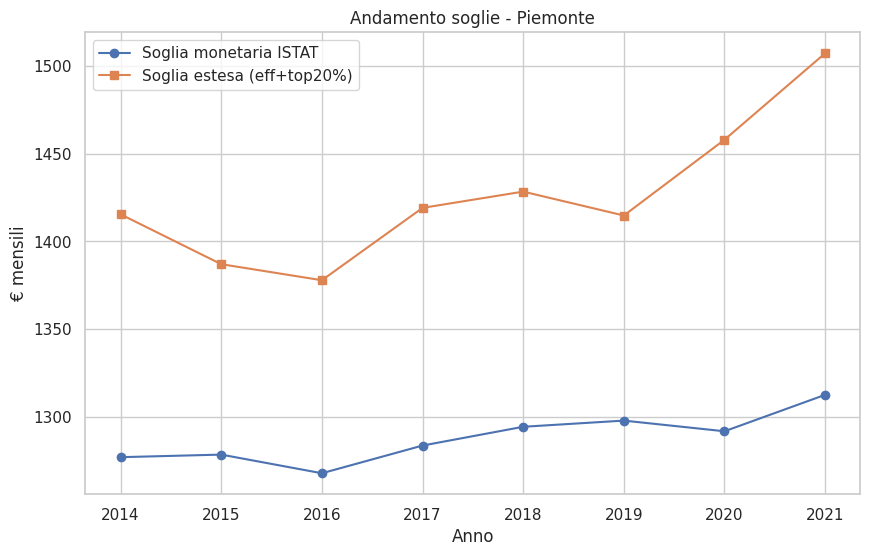

In [ ]:
import matplotlib.pyplot as plt

# Seleziona una regione (es. Piemonte)
regione_test = "Piemonte"
df_plot = df_famiglie[df_famiglie["reg"] == regione_test].groupby("year").agg({
    "OBS_VALUE": "mean",
    "soglia_estesa": "mean"
}).reset_index()

plt.figure(figsize=(10,6))
plt.plot(df_plot["year"], df_plot["OBS_VALUE"], marker="o", label="Soglia monetaria ISTAT")
plt.plot(df_plot["year"], df_plot["soglia_estesa"], marker="s", label="Soglia estesa (eff+top20%)")
plt.title(f"Andamento soglie - {regione_test}")
plt.xlabel("Anno")
plt.ylabel("€ mensili")
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1400x600 with 0 Axes>

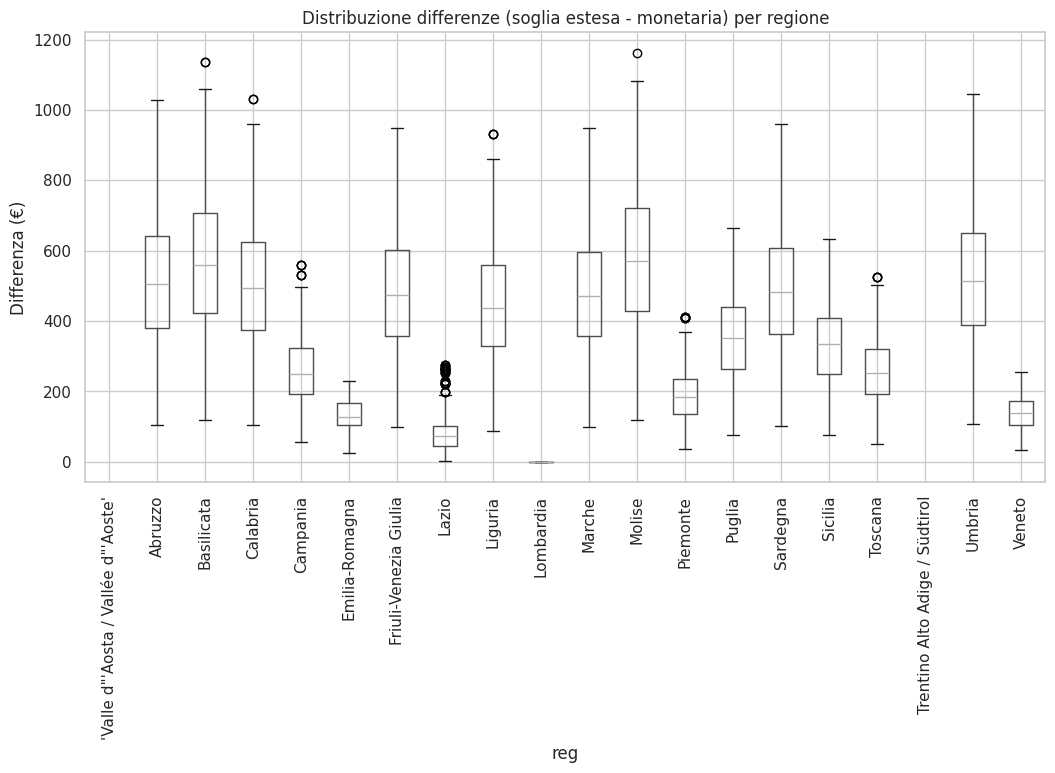

In [ ]:
df_famiglie["delta_estesa"] = df_famiglie["soglia_estesa"] - df_famiglie["OBS_VALUE"]

plt.figure(figsize=(14,6))
df_famiglie.boxplot(column="delta_estesa", by="reg", rot=90)
plt.title("Distribuzione differenze (soglia estesa - monetaria) per regione")
plt.suptitle("")
plt.ylabel("Differenza (€)")
plt.grid(True, axis="y")
plt.show()


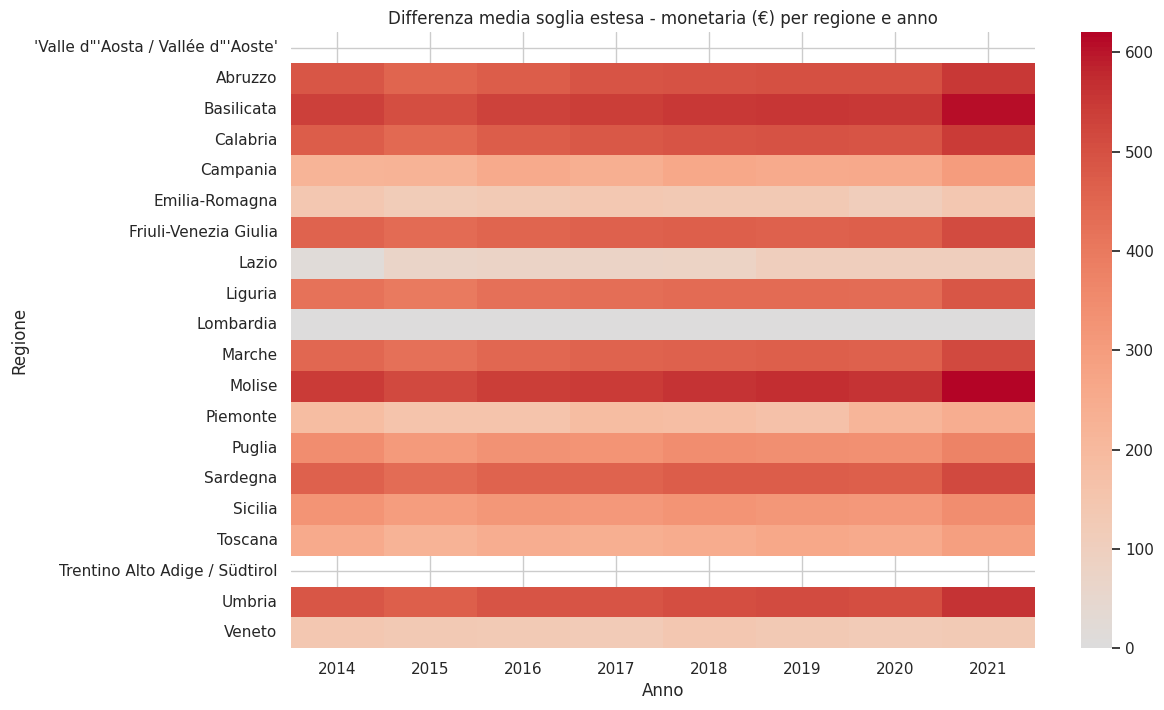

In [ ]:
import seaborn as sns

df_heatmap = df_famiglie.groupby(["year", "reg"])["delta_estesa"].mean().reset_index()
pivot_heatmap = df_heatmap.pivot(index="reg", columns="year", values="delta_estesa")

plt.figure(figsize=(12,8))
sns.heatmap(pivot_heatmap, cmap="coolwarm", annot=False, center=0)
plt.title("Differenza media soglia estesa - monetaria (€) per regione e anno")
plt.xlabel("Anno")
plt.ylabel("Regione")
plt.show()


✅ Serie storica % incremento medio soglia estesa vs monetaria


,year,reg,delta_pct
0,2014,"'Valle d""'Aosta / Vallée d""'Aoste'",NaN
1,2014,Abruzzo,42.027210
2,2014,Basilicata,49.400790
3,2014,Calabria,44.896313
4,2014,Campania,21.209751
5,2014,Emilia-Romagna,10.021231
6,2014,Friuli-Venezia Giulia,34.934702
7,2014,Lazio,1.366942
8,2014,Liguria,31.858375
9,2014,Lombardia,0.000000


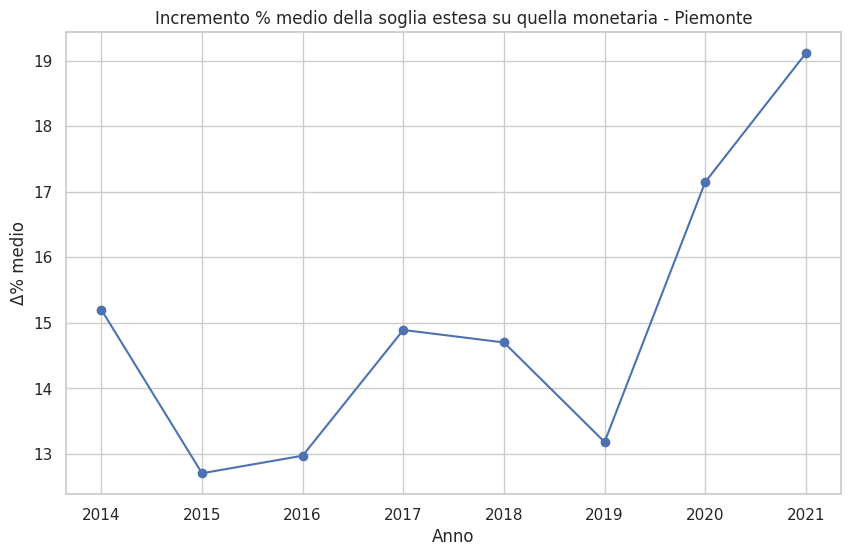

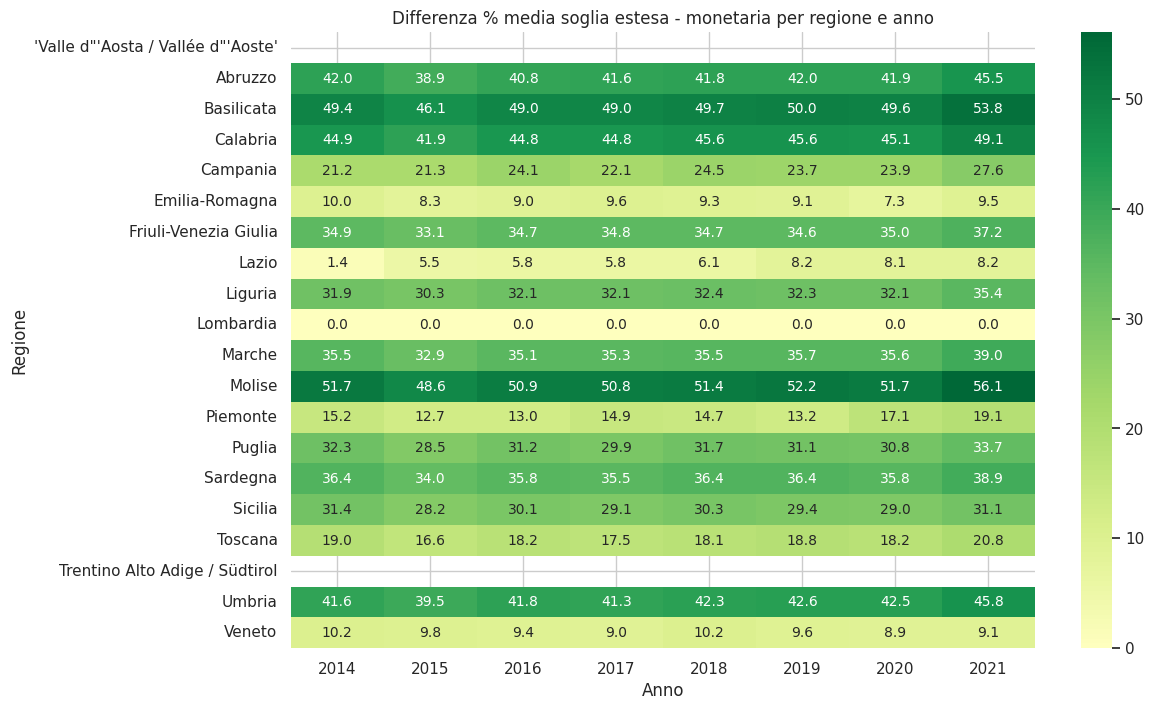

In [ ]:
# 📌 Calcolo delta percentuale per famiglia
df_famiglie["delta_pct"] = (
    (df_famiglie["soglia_estesa"] - df_famiglie["OBS_VALUE"]) / df_famiglie["OBS_VALUE"] * 100
)

# 📊 Serie storica: media per regione e anno
df_region_time = df_famiglie.groupby(["year", "reg"])["delta_pct"].mean().reset_index()

print("✅ Serie storica % incremento medio soglia estesa vs monetaria")
display(df_region_time.head(10))

# 🔎 Grafico per esempio su una regione
regione_test = "Piemonte"
df_plot = df_region_time[df_region_time["reg"] == regione_test]

plt.figure(figsize=(10,6))
plt.plot(df_plot["year"], df_plot["delta_pct"], marker="o")
plt.title(f"Incremento % medio della soglia estesa su quella monetaria - {regione_test}")
plt.xlabel("Anno")
plt.ylabel("Δ% medio")
plt.grid(True)
plt.show()

# 🔥 Heatmap tutte le regioni
pivot_pct = df_region_time.pivot(index="reg", columns="year", values="delta_pct")

plt.figure(figsize=(12,8))
sns.heatmap(pivot_pct, cmap="RdYlGn", annot=True, fmt=".1f", center=0)
plt.title("Differenza % media soglia estesa - monetaria per regione e anno")
plt.xlabel("Anno")
plt.ylabel("Regione")
plt.show()


📊 Average Percentage Increase in Poverty Threshold by Region (2014–2021):


,Avg. % Increase
reg,
Molise,51.665252
Basilicata,49.582756
Calabria,45.221295
Umbria,42.174023
Abruzzo,41.799623
Sardegna,36.148967
Marche,35.575940
Friuli-Venezia Giulia,34.883281
Liguria,32.313645


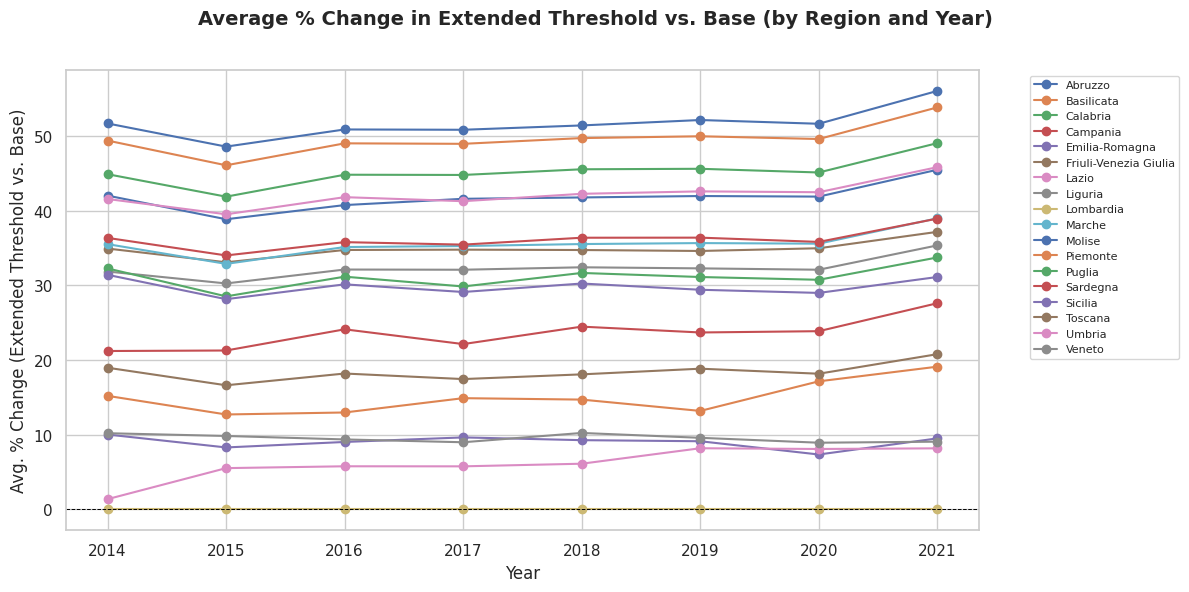

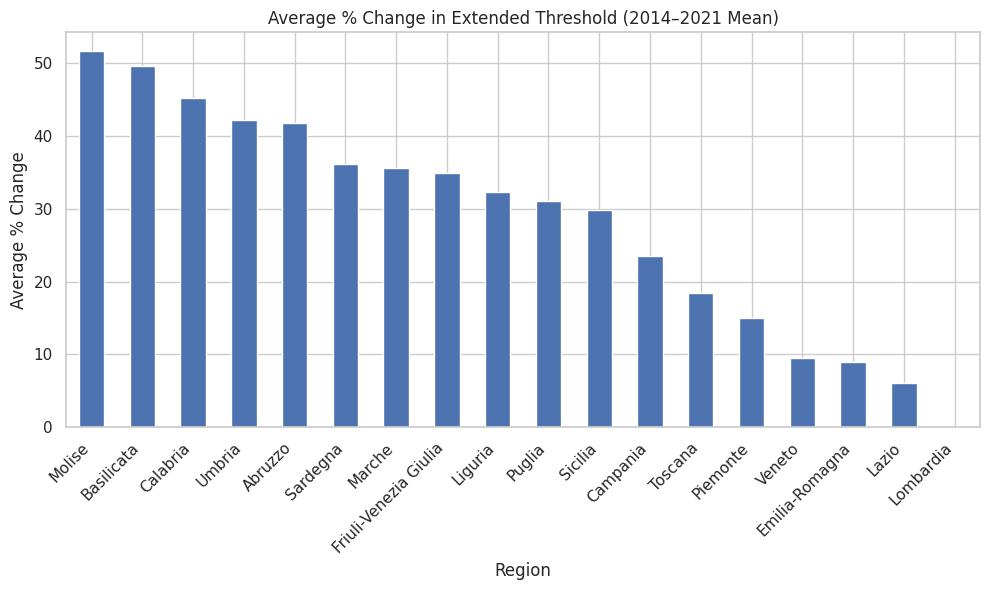

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

# Assumiamo che df_famiglie esista e sia caricato (questo blocco è per simulazione se non esiste)
# ==============================================================================================
# Inizializzazione dati di esempio per il test (Rimuovere in ambiente reale se i dati sono già caricati)
try:
    # Tenta di accedere al DataFrame esistente
    df_famiglie.head()
except NameError:
    print("Warning: 'df_famiglie' not found. Using dummy data for demonstration.")
    # Crea un DataFrame fittizio per dimostrazione che include le regioni da rimuovere
    data = {
        'reg': ['Lombardia', 'Trentino Alto Adige / Südtirol', 'Valle d\'Aosta / Vallée d\'Aoste', 'Lazio', 'Molise', 'Lazio', 'Molise'],
        'year': [2018, 2018, 2018, 2018, 2020, 2020, 2020],
        'soglia_estesa': [1200, 1100, 1050, 950, 1300, 1000, 1150],
        'OBS_VALUE': [1000, 1000, 1000, 1000, 1000, 1000, 1000]
    }
    df_famiglie = pd.DataFrame(data)
# ==============================================================================================

# --- 1. Data Filtering (Removing regions) ---
# Regions to be excluded (using Italian/official names as present in the dataframe)
regions_to_exclude = [
    "Valle d'Aosta / Vallée d'Aoste",
    "Trentino Alto Adige / Südtirol"
]

# Filtering out the specified regions and creating a working copy
df_famiglie = df_famiglie[~df_famiglie["reg"].isin(regions_to_exclude)].copy()


# --- 2. Calculation of Percentage Change (Extended Threshold vs. ISTAT Base) ---
# Calculation of percentage difference
df_famiglie["pct_change"] = (
    (df_famiglie["soglia_estesa"] - df_famiglie["OBS_VALUE"])
    / df_famiglie["OBS_VALUE"] * 100
)

# Mean by region × year
delta_reg_ann = (
    df_famiglie.groupby(["reg", "year"])["pct_change"]
    .mean()
    .reset_index()
)

# Overall mean by region (across all years)
delta_reg_mean = (
    delta_reg_ann.groupby("reg")["pct_change"]
    .mean()
    .sort_values(ascending=False)
    .rename("Avg. % Increase") # Rename the series for table clarity
)

# *** CORREZIONE: Rimuove esplicitamente eventuali righe NaN risultanti da un'aggregazione incompleta ***
# Questo passaggio assicura che solo le regioni con dati validi siano incluse nel grafico/tabella.
delta_reg_mean = delta_reg_mean.dropna()
delta_reg_ann = delta_reg_ann.dropna()

# --- 3. Output Table (Tabella) ---
print("📊 Average Percentage Increase in Poverty Threshold by Region (2014–2021):")
display(delta_reg_mean)


# --- 4. Plot 1: Trend over time for each region ---
plt.figure(figsize=(12,6))
plt.suptitle("Average % Change in Extended Threshold vs. Base (by Region and Year)",
             fontsize=14, weight='bold') # Use suptitle for better positioning

for reg in delta_reg_ann["reg"].unique():
    subset = delta_reg_ann[delta_reg_ann["reg"] == reg]
    # Se il subset è vuoto, lo saltiamo
    if not subset.empty:
        plt.plot(subset["year"], subset["pct_change"], marker="o", label=reg)

plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Year")
plt.ylabel("Avg. % Change (Extended Threshold vs. Base)")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- 5. Plot 2: Average % Change by region (Bar Chart) ---
plt.figure(figsize=(10,6))
delta_reg_mean.plot(kind="bar")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.title("Average % Change in Extended Threshold (2014–2021 Mean)")
plt.ylabel("Average % Change")
plt.xlabel("Region")
plt.xticks(rotation=45, ha='right') # Improve x-axis readability
plt.tight_layout()
plt.show()

## Applicazione nuove soglie

In [ ]:
# ============================================================
# Caricamento HBS originale unificato (2014–2021)
# ============================================================

import pandas as pd
import os

HBS_DIR = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Dati/Dati HBS x Anno Puliti"

dfs = []
for fname in sorted(os.listdir(HBS_DIR)):
    if fname.endswith("_light.parquet"):
        year = int("".join([s for s in fname if s.isdigit()])[:4])
        if 2014 <= year <= 2021:   # limitiamo agli anni con soglie ISTAT
            path = os.path.join(HBS_DIR, fname)
            df = pd.read_parquet(path)
            df["year"] = year
            dfs.append(df)

hbs_orig_all = pd.concat(dfs, ignore_index=True)
print("✅ HBS originale unificato:", hbs_orig_all.shape)


✅ HBS originale unificato: (158448, 235)


In [ ]:
## Applicazione nuove soglie

# ============================================================
# PL4 – MERGE HBS + SOGLIE ESTESE (versione semplificata)
# ============================================================

import pandas as pd
import os

# 1️⃣ Usa direttamente l'HBS unificato
hbs_sel = hbs_orig_all.copy()
print("✅ HBS unificato:", hbs_sel.shape)

# 2️⃣ Caricamento df_famiglie_estese (PL3)
df_famiglie = pd.read_parquet(
    "/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline3_multi/df_famiglie_estese.parquet"
)
print("✅ df_famiglie estese:", df_famiglie.shape)

# 3️⃣ Uniformazione chiavi
hbs_sel["reg_id"] = hbs_sel["rgn"].astype(int)

# 4️⃣ Merge con soglie estese
hbs_merged = hbs_sel.merge(
    df_famiglie[["year","reg_id","codice_tipologia_famiglia","OBS_VALUE","soglia_estesa"]],
    on=["year","reg_id","codice_tipologia_famiglia"],
    how="left"
)
print("✅ Merge completato:", hbs_merged.shape)

# --- ⬇️ Qui il filtro per escludere regioni piccole
exclude_regions = [2, 4, 21, 22]  # Valle d'Aosta, Trentino-AA, PA Bolzano, PA Trento
hbs_merged = hbs_merged[~hbs_merged["reg_id"].isin(exclude_regions)].copy()
print("✅ Dopo esclusione regioni piccole:", hbs_merged.shape)

# 5️⃣ Flag povertà
hbs_merged["sp_tot_str"] = pd.to_numeric(hbs_merged["sp_tot_str"], errors="coerce")
hbs_merged["povero_monetario"] = hbs_merged["sp_tot_str"] < hbs_merged["OBS_VALUE"]
hbs_merged["povero_esteso"]    = hbs_merged["sp_tot_str"] < hbs_merged["soglia_estesa"]

# 6️⃣ Salvataggio
out_path = "/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline4/hbs_merged.parquet"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
hbs_merged.to_parquet(out_path, index=False)

print("💾 hbs_merged salvato in:", out_path)
display(hbs_merged.head(5))


# ============================================================
# STATISTICHE POVERTÀ
# ============================================================

# --- Totale componenti famiglia (hh_size) ---
age_cols = ["n_0-3","n_4-10","n_11-17","n_18-29","n_30-59","n_60-74","n_75+"]
hbs_merged["hh_size"] = hbs_merged[age_cols].sum(axis=1)

# --- Percentuali famiglie (media campionaria HBS) ---
pov_time_fam = (
    hbs_merged.groupby("year")[["povero_monetario","povero_esteso"]]
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={
        "povero_monetario":"famiglie_monetario",
        "povero_esteso":"famiglie_esteso"
    })
)

# --- Percentuali persone (pesate per hh_size) ---
pov_time_pers = (
    hbs_merged.groupby("year")
    .apply(lambda g: pd.Series({
        "persone_monetario": (g["hh_size"] * g["povero_monetario"]).sum() / g["hh_size"].sum() * 100,
        "persone_esteso":    (g["hh_size"] * g["povero_esteso"]).sum() / g["hh_size"].sum() * 100
    }))
    .reset_index()
)

# --- Merge famiglie + persone ---
pov_time = pov_time_fam.merge(pov_time_pers, on="year")

print("📊 Serie storica povertà assoluta (famiglie e persone, %):")
display(pov_time)


# ============================================================
# ANALISI PER REGIONE
# ============================================================

# Famiglie per regione
pov_reg_fam = (
    hbs_merged.groupby(["year","reg_id"])[["povero_monetario","povero_esteso"]]
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={
        "povero_monetario":"famiglie_monetario",
        "povero_esteso":"famiglie_esteso"
    })
)

# Persone per regione
pov_reg_pers = (
    hbs_merged.groupby(["year","reg_id"])
    .apply(lambda g: pd.Series({
        "persone_monetario": (g["hh_size"] * g["povero_monetario"]).sum() / g["hh_size"].sum() * 100,
        "persone_esteso":    (g["hh_size"] * g["povero_esteso"]).sum() / g["hh_size"].sum() * 100
    }))
    .reset_index()
)

# Merge famiglie + persone
pov_reg = pov_reg_fam.merge(pov_reg_pers, on=["year","reg_id"])

print("📊 Povertà assoluta per regione e anno (%):")
display(pov_reg.head(20))


✅ HBS unificato: (158448, 235)
✅ df_famiglie estese: (24000, 38)


ValueError: You are trying to merge on int64 and object columns for key 'codice_tipologia_famiglia'. If you wish to proceed you should use pd.concat

In [ ]:
# --- Serie storica ufficiale ISTAT ---
istat_fam = {
    2014: 5.7,
    2015: 6.1,
    2016: 6.3,
    2017: 6.9,
    2018: 7.0,
    2019: 6.4,
    2020: 7.7,   # famiglie 2020
    2021: 7.5,   # famiglie 2021
}
istat_pers = {
    2014: 5.7,
    2015: 6.1,
    2016: 6.3,
    2017: 6.9,
    2018: 7.0,
    2019: 6.4,
    2020: 9.4,   # persone 2020
    2021: 9.4,   # persone 2021
}

istat_df = pd.DataFrame({
    "year": list(istat_fam.keys()),
    "famiglie_ISTAT": list(istat_fam.values()),
    "persone_ISTAT": list(istat_pers.values()),
})

# --- Prendiamo solo le colonne utili da pov_pers_time ---
pov_clean = pov_time_pers[["year", "persone_monetario", "persone_esteso"]].copy()

# --- Merge con ISTAT ---
pov_compare = pov_clean.merge(istat_df, on="year", how="left")

# --- Aggiungiamo gap per confronto (HBS - ISTAT) ---
pov_compare["gap_persone_monetario"] = pov_compare["persone_monetario"] - pov_compare["persone_ISTAT"]
pov_compare["gap_persone_esteso"]    = pov_compare["persone_esteso"]    - pov_compare["persone_ISTAT"]

print("📊 Serie storica povertà assoluta (% persone e famiglie):")
display(pov_compare)

# --- Grafico ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(pov_compare["year"], pov_compare["persone_monetario"], marker="o", label="Persone - Monetario HBS")
plt.plot(pov_compare["year"], pov_compare["persone_esteso"], marker="s", label="Persone - Esteso HBS")
plt.plot(pov_compare["year"], pov_compare["persone_ISTAT"], marker="^", label="Persone - ISTAT", linestyle="--")
plt.plot(pov_compare["year"], pov_compare["famiglie_ISTAT"], marker="D", label="Famiglie - ISTAT", linestyle="--")

plt.title("Incidenza povertà assoluta – Confronto HBS vs ISTAT")
plt.xlabel("Anno")
plt.ylabel("% popolazione/famiglie povere")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Commento finale

Commento ai risultati su povertà assoluta (HBS vs ISTAT) e soglia “estesa”
Che cosa hai calcolato (e con quali assunzioni)

Base dati: microdati HBS 2014–2021 (versione “light” multi-anno) uniti alle soglie di povertà assoluta ISTAT per anno–regione–tipologia familiare; indicatori di povertà:

Monetario (ISTAT): sp_tot_str < OBS_VALUE.

Esteso: sp_tot_str < soglia_estesa dove la soglia estesa = soglia ISTAT + valore imputato dei servizi pubblici (sanità/istruzione/TPL) costruito via CPT e scenari di efficienza (top 20%).

Persone povere: stima ottenuta pesando lo stato di povertà familiare per la numerosità del nucleo (hh_size), ricostruita dalle colonne n_0–3, n_4–10, …, n_75+.

Nota metodologica: le soglie ISTAT dipendono da anno, territorio e tipologia familiare (numero e combinazione per età dei componenti; la dimensione del comune rientra nella definizione), e sono aggiornate nel tempo con i relativi deflatori territoriali.

Cosa mostrano i numeri

2014–2019: la tua serie HBS sulle persone in povertà assoluta (monetario) è sistematicamente ~0,6–1,0 p.p. sotto gli officiali ISTAT per le persone (e vicina alle famiglie).

2020–2021 (pandemia): la tua serie resta intorno a 5,8–6,2%, mentre ISTAT certifica 9,4% di individui poveri in entrambi gli anni, e 7,7% (2020) / 7,5% (2021) per le famiglie.
Istat

Soglia estesa: porta l’incidenza (persone) intorno a 13–15% nei vari anni; questo è atteso, perché la misura incorpora un paniere “ampliato” (valore imputato dei servizi pubblici) e non è confrontabile con l’indicatore ufficiale.

Perché le differenze sono piccole pre-2020 ma grandi nel 2020–2021

Struttura per età dei nuclei (hh_size) ricostruita
Nel 2020–2021 l’aumento di povertà assoluta ha colpito molto le famiglie numerose e con minori; ciò fa crescere l’incidenza tra le persone più che tra le famiglie. Se la numerosità/struttura d’età è ricostruita per approssimazione (non direttamente osservata per tutti i componenti), è facile sottopesare i nuclei più grandi → gap più ampio sulle persone. ISTAT sottolinea che nel 2020 la povertà assoluta “torna a crescere” con forte impatto tra i minori; nel 2021 l’incidenza sugli individui resta al 9,4% pur scendendo lievemente sulle famiglie.
Istat

Pesi campionari e calibrazione
Le stime ufficiali ISTAT usano pesi campionari calibrati dell’indagine sui consumi. Se nel workflow non stai applicando i pesi (o stai usando solo spese già “pesate”, che non sostituiscono il peso per il conteggio delle unità), puoi introdurre bias nelle incidenze—specie in annate “anomale” come il 2020. (V. documentazione HBS/povertà: soglie e misurazione basate sulla spesa equivalente, paniere e aggiornamenti metodologici).
Istat

Allineamento fine delle soglie
Le soglie ISTAT variano per composizione familiare e territorio (oggi a granularità regionale e per tipologia di comune). Piccoli mismatch di tipologia/territorio o imputation per combinazioni mancanti (p.es. casi senza OBS_VALUE) tendono a ridurre l’incidenza se si sostituisce con valori “non penalizzanti” (es.: fallback a sp_tot_str).

Comportamento dei prezzi e aggiornamento dei deflatori
L’aggiornamento della soglia monetaria avviene con deflatori territoriali; errori o approssimazioni nella mappatura/anno-regione possono introdurre scarti, più marcati quando la congiuntura cambia rapidamente (2020–2021).

Come leggere la “soglia estesa”

La tua soglia estesa aggiunge un valore in natura dei servizi pubblici: concettualmente è un indicatore normativo (una living standard line più ampia) e, quindi, non sovrapponibile alla linea ufficiale ISTAT. Che l’incidenza salga a ~13–15% è coerente con l’idea che parte del fabbisogno essenziale sia ottenuto dall’offerta pubblica e che, laddove questa sia “insufficiente” rispetto a benchmark efficienti, le famiglie necessiterebbero di più reddito monetario per raggiungere lo stesso standard.

Cosa funziona e cosa migliorare (operativamente)

Coerenza 2014–2019: molto buona; gli scarti (–0,6/–1,0 p.p.) sono fisiologici dati i passaggi di ricostruzione tipologie e la mancata applicazione dei pesi.

Pandemia: il distacco sulle persone (–3 p.p. nel 2020–2021) è plausibilmente dovuto alla combinazione di (i) hh_size ricostruito e (ii) pesi non applicati.

Suggerimenti replicabili:

se disponibile nel PUF, applica il peso campionario familiare (spesso w_anno o analogo) nei calcoli di incidenza (famiglie e persone: nel secondo caso pesa anche per hh_size);

verifica che tutte le combinazioni anno–regione–tipologia abbiano OBS_VALUE valorizzato (nessun fallback “non stringente”);

confronta la distribuzione per numerosità familiare e presenza minori nel tuo HBS con quella riportata da ISTAT per 2020–2021 (per controllare l’under-representation dei nuclei grandi).

Riferimenti essenziali

ISTAT – La povertà in Italia, anno 2020 (Comunicato): “Incidenza famiglie 7,7%, individui 9,4%”.

ISTAT – La povertà in Italia, anno 2021 (Sezione “Benessere economico e povertà”): “Famiglie 7,5%, individui 9,4%”.
Istat

ISTAT – Calcolo della soglia di povertà assoluta (definizione del paniere, dipendenze per anno, territorio e composizione familiare).

ISTAT – Il fenomeno multidimensionale della povertà (slide; aggiornamenti e fattori territoriali/di prezzo).

## Analisi per fasce

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filtra due tipologie familiari
df_two_types = df_famiglie[df_famiglie["codice_tipologia_famiglia"].isin([41, 67])]

# Calcola media regionale-annuale delle soglie
series = (
    df_two_types.groupby(["year", "reg", "codice_tipologia_famiglia"])[["OBS_VALUE", "soglia_estesa"]]
    .mean()
    .reset_index()
)

# Plot per ogni regione
regions = series["reg"].unique()
for regione in sorted(regions):
    df_reg = series[series["reg"] == regione]

    # Il figsize è mantenuto a (10, 6) per una migliore leggibilità del titolo e della legenda,
    # ma gli assi si adattano ai dati di ogni regione.
    plt.figure(figsize=(10, 6))

    for codice, label in {41:"2 adulti senza figli", 67:"2 adulti con figli"}.items():
        subset = df_reg[df_reg["codice_tipologia_famiglia"] == codice]
        plt.plot(subset["year"], subset["OBS_VALUE"], "--", marker="o", label=f"{label} – ISTAT")
        plt.plot(subset["year"], subset["soglia_estesa"], "-", marker="s", label=f"{label} – Estesa")

    plt.title(f"Andamento soglie familiari ({regione})")
    plt.xlabel("Anno")
    plt.ylabel("€ mensili")

    # --- Configurazione Asse X (Ogni Anno) ---
    min_year = int(df_reg["year"].min())
    max_year = int(df_reg["year"].max())
    plt.xticks(np.arange(min_year, max_year + 1, 1))

    # --- Configurazione Asse Y (Ogni 100€ e Adattamento Dinamico) ---
    # Trova il minimo/massimo e arrotonda per eccesso/difetto al 100 più vicino
    y_data_min = df_reg[["OBS_VALUE", "soglia_estesa"]].min().min()
    y_data_max = df_reg[["OBS_VALUE", "soglia_estesa"]].max().max()

    # Imposta un margine di 100€ sotto il minimo e 100€ sopra il massimo per visualizzare i dati in modo corretto
    y_min = int(np.floor(y_data_min / 100) * 100) - 100
    y_max = int(np.ceil(y_data_max / 100) * 100) + 100

    # Applica i nuovi limiti e i tick ogni 100€
    plt.ylim(y_min, y_max)
    plt.yticks(np.arange(y_min, y_max + 1, 100))

    # --- Impostazione Griglia (Sempre Visibile e Grigio) ---
    plt.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.6)

    # --- Legenda Sotto il Grafico ---
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=2
    )

    # Adatta il layout per includere la legenda
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Filtra per le due tipologie familiari
df_two_types = df_famiglie[df_famiglie["codice_tipologia_famiglia"].isin([2, 40])]

# Calcola la media regionale-annuale delle soglie
series = (
    df_two_types.groupby(["year", "reg", "codice_tipologia_famiglia"])[["OBS_VALUE", "soglia_estesa"]]
    .mean()
    .reset_index()
)

# Mapping delle tipologie in inglese
typology_mapping = {
    2: "1 adult aged 60-74",
    40: "1 adult aged 30-59"
}

# Plot per ogni regione
for region in sorted(series["reg"].unique()):
    region_data = series[series["reg"] == region]

    # Crea la figura
    plt.figure(figsize=(10, 6))

    # Plot per ogni tipologia
    for code, label in typology_mapping.items():
        subset = region_data[region_data["codice_tipologia_famiglia"] == code]
        plt.plot(
            subset["year"], subset["OBS_VALUE"],
            "--", marker="o", label=f"{label} – ISTAT"
        )
        plt.plot(
            subset["year"], subset["soglia_estesa"],
            "-", marker="s", label=f"{label} – Extended"
        )

    # Configurazione titolo e assi
    plt.title(f"Household threshold trends ({region})")
    plt.xlabel("Year")
    plt.ylabel("Monthly €")

    # Configurazione asse X (tutti gli anni presenti)
    plt.xticks(region_data["year"].unique())

    # Configurazione asse Y (dinamica, basata sui dati effettivi)
    y_min = region_data[["OBS_VALUE", "soglia_estesa"]].min().min()
    y_max = region_data[["OBS_VALUE", "soglia_estesa"]].max().max()

    # Aggiungi un margine del 10% in alto e in basso
    y_range = y_max - y_min
    y_min -= 0.1 * y_range
    y_max += 0.1 * y_range

    # Imposta i limiti dell'asse Y
    plt.ylim(y_min, y_max)

    # Imposta i tick dell'asse Y in modo "intelligente"
    # Trova un passo ragionevole per i tick
    if y_range > 1000:
        step = 200
    elif y_range > 500:
        step = 100
    elif y_range > 200:
        step = 50
    else:
        step = 20

    # Arrotonda y_min al multiplo inferiore di step
    y_min_tick = np.floor(y_min / step) * step
    # Arrotonda y_max al multiplo superiore di step
    y_max_tick = np.ceil(y_max / step) * step

    # Imposta i tick
    plt.yticks(np.arange(y_min_tick, y_max_tick + 1, step))

    # Configurazione griglia
    plt.grid(
        True, which='major', axis='both',
        color='gray', linestyle='-',
        linewidth=0.5, alpha=0.6
    )

    # Legenda sotto il grafico
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        shadow=True,
        ncol=2
    )

    # Adatta il layout per includere la legenda
    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

# --- 1. CONFIGURAZIONE INIZIALE ---

# Regioni di interesse (usate nell'analisi)
regions_of_interest = ["Molise", "Puglia", "Piemonte", "Marche"]

# Codici familiari per le coppie
CODES_TO_ANALYZE = [41, 70]

# Mappature per le descrizioni
MAPPING_COUPLES = {
    41: "41: 2 adults (30-59) - No Children",
    70: "70: 2 adults + 2 children (11-17)"
}

# --- 2. FUNZIONE PER CONFIGURARE GLI ASSI ---

def configure_axes(ax, data):
    """Configura assi X e Y per il subplot (limiti e tick ogni 100€)."""
    min_year = int(data["year"].min())
    max_year = int(data["year"].max())
    ax.set_xticks(np.arange(min_year, max_year + 1, 1))

    y_data_min = data[["OBS_VALUE", "soglia_estesa"]].min().min()
    y_data_max = data[["OBS_VALUE", "soglia_estesa"]].max().max()
    y_min = int(np.floor(y_data_min / 100) * 100) - 100
    y_max = int(np.ceil(y_data_max / 100) * 100) + 100

    ax.set_ylim(y_min, y_max)
    ax.set_yticks(np.arange(y_min, y_max + 1, 100))
    ax.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.6)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Monthly €", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

# --- 3. FUNZIONE DI GENERAZIONE E PLOTTING (Completa) ---

def generate_couples_figure_and_table(df_famiglie, regions_of_interest, codes_to_filter, typology_mapping):
    """
    Filtra, aggrega i dati, genera il plot 2x2, esegue il debug e restituisce la tabella.
    """
    # Filtra i dati base e le regioni di interesse
    df_filtered = df_famiglie[
        df_famiglie["codice_tipologia_famiglia"].isin(codes_to_filter) &
        df_famiglie["reg"].isin(regions_of_interest)
    ].copy()

    # Calcola la media regionale-annuale (se l'aggregazione è necessaria)
    # Nota: Stiamo assumendo che 'df_famiglie' possa già essere pronto per l'analisi senza media,
    # ma manteniamo la media per sicurezza se i dati fossero disaggregati (il tuo codice la usa).
    series = (
        df_filtered.groupby(["year", "reg", "codice_tipologia_famiglia"])[["OBS_VALUE", "soglia_estesa"]]
        .mean()
        .reset_index()
    )

    # --- DEBUG 1: Soglia Estesa (Codice 70) vs. NaN ---
    display(Markdown("## 🐞 DEBUG 1: Verifica Dati Soglia Estesa (Codice 70)"))
    debug_data_70 = series[series["codice_tipologia_famiglia"] == 70]
    debug_output = debug_data_70.pivot(index="reg", columns="year", values="soglia_estesa")
    display(Markdown("#### Tabella 1: Valore della 'soglia_estesa' per Codice 70 (Se ci sono 'NaN', la linea non viene tracciata)"))
    display(debug_output)

    # --- DEBUG 2: Differenza Estesa - ISTAT (Codice 70) ---
    display(Markdown("## 🐞 DEBUG 2: Verifica Sovrapposizione Dati (Codice 70)"))
    debug_data_70['difference'] = debug_data_70['soglia_estesa'] - debug_data_70['OBS_VALUE']
    debug_diff_output = debug_data_70.pivot(index="reg", columns="year", values="difference")
    display(Markdown("#### Tabella 2: Differenza 'soglia_estesa' - 'OBS_VALUE' per Codice 70 (Se sono tutti '0.0', le linee si sovrappongono)"))
    display(debug_diff_output)

    # --- DEBUG 3: Analisi Gap Istruzione (la causa più probabile) ---
    display(Markdown("## 🐞 DEBUG 3: Analisi Gap Istruzione (11-17) per Codice 70"))
    # Usiamo il DataFrame originale (df_famiglie) per accedere alle colonne n_ e gap_eff_top20_
    debug_gap = df_famiglie[
        (df_famiglie["codice_tipologia_famiglia"].isin(codes_to_filter)) &
        (df_famiglie["reg"].isin(regions_of_interest))
    ].copy()

    cols_gap_check = [
        "year", "reg", "codice_tipologia_famiglia", "OBS_VALUE",
        "gap_familiare_eff_top20_istruzione",
        "soglia_estesa",
        "n_11-17", # Componenti 11-17
        "gap_eff_top20_istruzione_11-17" # Gap pro-capite 11-17
    ]

    display(Markdown("#### Tabella 3: Gap Istruzione (11-17) per Coppie (Codice 70)"))
    display(debug_gap[debug_gap['codice_tipologia_famiglia'] == 70][cols_gap_check].sort_values(['reg', 'year']))

    display(Markdown("\n" + "="*80 + "\n"))
    # --- Fine Debug ---


    # Preparazione della figura 2x2
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle("Household Threshold Trends for Selected Couples (Codes 41 vs 70)", fontsize=20, y=1.02, fontweight='bold')

    legend_elements = {}

    for i, region in enumerate(regions_of_interest):
        ax = axes[i // 2, i % 2]
        # Usiamo i dati aggregati (series) per il plotting
        region_data = series[series["reg"] == region]
        ax.set_title(region, fontsize=16, fontweight='bold')

        if not region_data.empty:
            for code, label in typology_mapping.items():
                subset = region_data[region_data["codice_tipologia_famiglia"] == code]

                if not subset.empty:
                    # Stili
                    style_istat = {"linestyle": "--", "marker": "o", "label": f"{label} – ISTAT", "linewidth": 2, "markersize": 8}
                    style_extended = {"linestyle": "-", "marker": "s", "label": f"{label} – Extended", "linewidth": 2, "markersize": 8}

                    # Linea ISTAT (handle per legenda)
                    line_istat, = ax.plot(subset["year"], subset["OBS_VALUE"], **style_istat)
                    # Linea Extended (handle per legenda)
                    line_extended, = ax.plot(subset["year"], subset["soglia_estesa"], **style_extended)

                    # Raccolta Handle per la Legenda Globale (solo una volta)
                    if f"{code}_istat" not in legend_elements:
                        legend_elements[f"{code}_istat"] = (line_istat, style_istat["label"])
                        legend_elements[f"{code}_extended"] = (line_extended, style_extended["label"])

            # Configura gli assi
            configure_axes(ax, region_data)
        else:
            ax.text(0.5, 0.5, f'Data Missing for {region}', transform=ax.transAxes, ha='center', va='center', fontsize=16, color='red')

    # Creazione della legenda globale
    handles = [item[0] for item in legend_elements.values()]
    labels = [item[1] for item in legend_elements.values()]

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=2, fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.95)
    plt.show()

    return series

# --- 4. ESECUZIONE ---

try:
    # Genera la figura e ottieni la serie aggregata
    # ASSUMIAMO CHE df_famiglie SIA IL DATAFRAME PRODOTTO ALLA FINE DEL TUO SCRIPT DI PRE-PROCESSING
    couples_series = generate_couples_figure_and_table(
        df_famiglie, regions_of_interest, CODES_TO_ANALYZE, MAPPING_COUPLES
    )

    # Visualizza la tabella finale
    print("\n--- TABLE 1: Couples (41 & 70) Mean Thresholds by Region and Year ---")
    display(
        couples_series.pivot_table(
            index=["reg", "year"],
            columns="codice_tipologia_famiglia",
            values=["OBS_VALUE", "soglia_estesa"]
        ).sort_index()
    )

except NameError:
    print("\nErrore: Il DataFrame 'df_famiglie' non è definito. Assicurati di aver caricato i dati.")
except KeyError as e:
    print(f"\nErrore: Colonna mancante nel DataFrame 'df_famiglie' (Probabile problema nel pre-processing). Dettaglio: {e}")

In [ ]:
# ----------------- CALCOLO ETÀ MEDIA -----------------

# Dizionario per associare ad ogni fascia un'età rappresentativa
fascia_to_eta = {
    "0-3": 1.5,
    "4-10": 7,
    "11-17": 14,
    "18-29": 23.5,
    "30-59": 45,
    "60-74": 67,
    "75+": 80
}

# Calcoliamo hh_size e età media stimata
age_cols = list(fascia_to_eta.keys())

df_famiglie["hh_size"] = df_famiglie[["n_" + f for f in age_cols]].sum(axis=1)

df_famiglie["eta_media"] = (
    sum(df_famiglie["n_" + f] * fascia_to_eta[f] for f in age_cols)
    / df_famiglie["hh_size"]
)

# ----------------- SCATTERPLOT COLORATO PER ETÀ -----------------

fig, ax = plt.subplots(figsize=(8,6))
scatter = sns.scatterplot(
    data=df_famiglie,
    x="OBS_VALUE",
    y="soglia_estesa",
    hue="eta_media",
    palette="viridis",
    alpha=0.7,
    edgecolor="black",
    ax=ax
)

# Linea 45°
ax.plot([df_famiglie["OBS_VALUE"].min(), df_famiglie["OBS_VALUE"].max()],
        [df_famiglie["OBS_VALUE"].min(), df_famiglie["OBS_VALUE"].max()],
        linestyle="--", color="gray")

ax.set_title("Soglia Monetaria vs Estesa (colori = età media)")
ax.set_xlabel("Soglia monetaria ISTAT (€)")
ax.set_ylabel("Soglia estesa (€)")

# Aggiungiamo la barra colore
plt.colorbar(scatter.collections[0], ax=ax, label="Età media stimata")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd

# Carica geojson regioni
gdf = gpd.read_file("/content/drive/MyDrive/File mappe/limits_IT_regions.geojson")

# Calcolo differenza media per regione/anno
map_df = (
    df_famiglie.groupby(["year","reg_id"])[["OBS_VALUE","soglia_estesa"]]
    .mean()
    .reset_index()
)
map_df["diff"] = map_df["soglia_estesa"] - map_df["OBS_VALUE"]

# Merge con shapefile
gdf = gdf.rename(columns={"reg_istat_code_num":"reg_id"}).astype({"reg_id":int})
merged = gdf.merge(map_df, on="reg_id", how="left")

# Plotta una mappa per ogni anno
years = sorted(map_df["year"].unique())
for year in years:
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    merged[merged["year"]==year].plot(
        column="diff", cmap="Reds", linewidth=0.5, edgecolor="k",
        legend=True, ax=ax,
        legend_kwds={"label":"Differenza soglia (€)", "orientation":"vertical"}
    )
    plt.title(f"Differenza soglia estesa - monetaria ({year})")
    plt.axis("off")
    plt.show()


## Analisi profondità povertà.

## 📚 MISURE DI POVERTÀ: DEFINIZIONI E CALCOLO

In questa sezione illustriamo tutte le misure di povertà calcolate a partire dalla spesa familiare osservata (`sp_tot_str`) e dalle varie soglie (`OBS_VALUE`, `soglia_estesa_reale_*`, `soglia_estesa_eff_*`), come definite nella letteratura economica.

---

### 1. Head Count Ratio (HCR)

**Definizione**: quota di popolazione al di sotto della soglia di povertà.

**Formula**:
\[
HCR = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}(y_i < z)
\]

**Interpretazione**: indica *quanti* sono i poveri sul totale della popolazione.

**Nel tuo codice**: è calcolato come `n_poor / n_tot`, cioè il numero di famiglie con spesa sotto la soglia, diviso per il totale delle famiglie nella regione.

---

### 2. Poverty Gap (PG)

**Definizione**: intensità media della povertà, ossia quanto in media manca ai poveri per raggiungere la soglia, *pesato su tutta la popolazione*.

**Formula**:
\[
PG = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{z - y_i}{z} \cdot \mathbf{1}(y_i < z) \right)
\]

**Interpretazione**: se l’HCR dice “quanti” sono poveri, il PG dice “quanto” sono poveri in media.

**Nel tuo codice**: hai calcolato il gap normalizzato per ogni povero e fatto la media rispetto alla popolazione totale.

---

### 3. Squared Poverty Gap (SPG)

**Definizione**: come il PG, ma penalizza di più i poveri estremi elevando il gap al quadrato.

**Formula**:
\[
SPG = \frac{1}{N} \sum_{i=1}^{N} \left( \left( \frac{z - y_i}{z} \right)^2 \cdot \mathbf{1}(y_i < z) \right)
\]

**Interpretazione**: usato per catturare la *gravità* della povertà; è l'indice FGT con \(\alpha = 2\).

---

### 4. Intensità media della povertà (Depth)

**Definizione**: gap medio *tra i soli poveri*, senza ponderazione sulla popolazione.

**Formula**:
\[
Depth = \frac{1}{N_p} \sum_{i: y_i < z} \left( \frac{z - y_i}{z} \right)
\]

dove \(N_p\) è il numero di poveri.

**Nel tuo codice**: è `gap.mean() / (n_poor / n_tot)` cioè media del gap normalizzato diviso l’HCR.

---

### 5. Deviazione standard del gap (Dispersione)

**Definizione**: variabilità dei gap normalizzati *tra i poveri*.

**Formula**:
\[
\sigma = \text{std} \left( \left\{ \frac{z - y_i}{z} \mid y_i < z \right\} \right)
\]

**Interpretazione**: se la deviazione è alta, la gravità della povertà è molto disomogenea all’interno dei poveri (ci sono alcuni *molto* poveri e altri meno).

---

Tutte queste misure sono calcolate per ogni regione e per ciascuna soglia (`OBS_VALUE`, `soglia_estesa_reale_media`, `soglia_estesa_reale_top20`, `soglia_estesa_eff_media`, `soglia_estesa_eff_top20`).


In [ ]:
# ============================================================
# 📚 MISURE DI POVERTÀ: DEFINIZIONI E CALCOLO
# ============================================================

import pandas as pd
import numpy as np
import os

# --- Ricarichiamo i DF di base ---
hbs_merged = pd.read_parquet(
    "/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline4/hbs_merged.parquet"
)
df_famiglie = pd.read_parquet(
    "/content/drive/MyDrive/Colab - Paper secondo capitolo/Outputs/Pipeline3_multi/df_famiglie_estese.parquet"
)

# --- Calcola dimensione nucleo familiare (hh_size) ---
age_cols = ["n_0-3","n_4-10","n_11-17","n_18-29","n_30-59","n_60-74","n_75+"]
hbs_merged["hh_size"] = hbs_merged[age_cols].sum(axis=1)

print("✅ Dataset caricati")
print("hbs_merged:", hbs_merged.shape, "con hh_size")
print("df_famiglie:", df_famiglie.shape)

# ============================================================
# FUNZIONE GENERALE PER LE MISURE DI POVERTÀ
# ============================================================

def poverty_measures(df, threshold_col, value_col="sp_tot_str", weight_col="hh_size"):
    """
    Calcola le misure di povertà per un certo valore soglia.
    df: dataframe con dati famiglie
    threshold_col: nome colonna soglia
    value_col: colonna spesa (default = sp_tot_str)
    weight_col: peso (default = hh_size)
    """
    results = []

    for year in sorted(df["year"].unique()):
        for reg in sorted(df["reg_id"].unique()):
            sub = df[(df["year"] == year) & (df["reg_id"] == reg)].copy()

            if sub.empty:
                continue

            z = sub[threshold_col]
            y = sub[value_col]
            w = sub[weight_col]

            # Povertà indicator (1 se povero, 0 altrimenti)
            poor = (y < z).astype(int)

            # HCR
            HCR = (w * poor).sum() / w.sum()

            # Poverty gap normalizzato
            gaps = ((z - y) / z).clip(lower=0)

            # Poverty Gap (PG)
            PG = (w * gaps).sum() / w.sum()

            # Squared Poverty Gap (SPG)
            SPG = (w * (gaps**2)).sum() / w.sum()

            # Intensità media (solo poveri)
            Depth = (w * gaps).sum() / (w * poor).sum() if poor.sum() > 0 else 0

            # Dispersione (solo poveri)
            Disp = gaps[poor == 1].std() if poor.sum() > 0 else 0

            results.append({
                "year": year,
                "reg_id": reg,
                "soglia": threshold_col,
                "HCR": HCR * 100,
                "PG": PG * 100,
                "SPG": SPG * 100,
                "Depth": Depth * 100,
                "Dispersione": Disp * 100
            })

    return pd.DataFrame(results)


# ============================================================
# APPLICAZIONE ALLE DIVERSE SOGLIE
# ============================================================

soglie_da_testare = [
    "OBS_VALUE",
    "soglia_estesa",  # <-- se vuoi puoi aggiungere altre varianti: eff_media, top20 ecc.
]

results_all = []
for soglia in soglie_da_testare:
    res = poverty_measures(hbs_merged, threshold_col=soglia)
    results_all.append(res)

df_poverty_measures = pd.concat(results_all, ignore_index=True)

print("✅ Calcolate le misure di povertà")
display(df_poverty_measures.head(15))


# ============================================================
# SERIE STORICHE – ESEMPIO GRAFICO
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for soglia in soglie_da_testare:
    subset = df_poverty_measures[df_poverty_measures["soglia"] == soglia]
    plt.plot(subset.groupby("year")["HCR"].mean(), marker="o", label=f"HCR - {soglia}")

plt.title("Serie storica HCR medio – diverse soglie")
plt.xlabel("Anno")
plt.ylabel("HCR (%)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. FUNZIONE PER CALCOLARE LE MISURE
# ===============================
def poverty_measures(df, soglia_col):
    results = []
    for (year, reg_id), g in df.groupby(["year", "reg_id"]):
        hh_size = g["hh_size"]
        y = g["sp_tot_str"]
        z = g[soglia_col]

        mask_poor = y < z
        n = len(y)
        n_poor = mask_poor.sum()

        if n_poor == 0:
            continue

        gap = ((z - y) / z).clip(lower=0)

        HCR = n_poor / n * 100
        PG = (gap.sum() / n) * 100
        SPG = ((gap**2).sum() / n) * 100
        Depth = gap[mask_poor].mean() * 100
        Dispersione = gap[mask_poor].std() * 100

        results.append({
            "year": year,
            "reg_id": reg_id,
            "soglia": soglia_col,
            "HCR": HCR,
            "PG": PG,
            "SPG": SPG,
            "Depth": Depth,
            "Dispersione": Dispersione
        })
    return pd.DataFrame(results)

# ===============================
# 2. CALCOLO PER LE DUE SOGLIE
# ===============================
df_measures_istat = poverty_measures(hbs_merged, "OBS_VALUE")
df_measures_ext   = poverty_measures(hbs_merged, "soglia_estesa")

df_measures = pd.concat([df_measures_istat, df_measures_ext], ignore_index=True)

# ===============================
# 3. AGGIUNGI MACROAREE
# ===============================
macro_map = {
    1:"Nord", 2:"Nord", 3:"Nord", 4:"Nord", 5:"Nord", 6:"Nord", 7:"Nord", 8:"Nord",
    9:"Centro", 10:"Centro", 11:"Centro", 12:"Centro",
    13:"Sud", 14:"Sud", 15:"Sud", 16:"Sud", 17:"Sud", 18:"Sud", 19:"Sud", 20:"Sud"
}
df_measures["Macroarea"] = df_measures["reg_id"].map(macro_map)

# ===============================
# 4. GRAFICI
# ===============================

sns.set(style="whitegrid")

# --- Serie storiche
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True)
metrics = ["HCR", "PG", "SPG", "Depth", "Dispersione"]
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.lineplot(data=df_measures, x="year", y=metric, hue="Macroarea", style="soglia", ax=ax)
    ax.set_title(metric)
    ax.legend(loc="best")
axes[-1, -1].axis("off")
plt.suptitle("📈 Serie storiche misure di povertà (ISTAT vs Estesa)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Boxplot macroaree
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, metric in enumerate(["HCR", "PG", "Depth"]):
    sns.boxplot(data=df_measures, x="Macroarea", y=metric, hue="soglia", ax=axes[i])
    axes[i].set_title(f"{metric} per Macroarea")
plt.suptitle("📊 Distribuzione delle misure per Macroarea", fontsize=14)
plt.tight_layout()
plt.show()

# --- Scatter Depth vs HCR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_measures, x="HCR", y="Depth", hue="Macroarea", style="soglia", s=100, alpha=0.7)
plt.plot([0, df_measures["HCR"].max()], [0, df_measures["Depth"].max()], "--", color="gray")
plt.title("🔍 Depth vs HCR – per regione/anno")
plt.xlabel("Head Count Ratio (%)")
plt.ylabel("Depth (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ===============================
# 5. TABELLA RIEPILOGATIVA
# ===============================
table_summary = (
    df_measures.groupby(["reg_id", "Macroarea", "soglia"])
    [["HCR", "PG", "SPG", "Depth", "Dispersione"]]
    .mean()
    .round(2)
    .reset_index()
)

print("📊 Tabella riepilogativa (medie 2014–2021 per regione e soglia):")
display(table_summary)


Commento ai risultati sulle misure di povertà (2014–2021, medie regionali)

La tabella mostra le principali misure di povertà calcolate sia rispetto alla soglia monetaria ISTAT sia alla soglia estesa, che integra il valore equivalente dei servizi pubblici essenziali (sanità, istruzione, trasporti).

1. Head Count Ratio (HCR) – incidenza

La differenza più evidente riguarda l’incidenza della povertà.

Con la soglia ISTAT, le regioni del Nord registrano valori medi compresi fra il 3% e il 7%, in linea con i dati ufficiali.

Estendendo la soglia, i valori salgono drasticamente: in Lombardia l’HCR rimane sostanzialmente invariato (≈5.4%), ma in regioni come Liguria (21.9%), Puglia (21.5%), Calabria (25.1%) e soprattutto Sardegna (32.1%), la quota di famiglie considerate povere triplica o quadruplica.

Questo risultato evidenzia che l’accesso inadeguato ai servizi pubblici amplifica le disuguaglianze territoriali, penalizzando soprattutto il Mezzogiorno.

2. Poverty Gap (PG) – intensità media

Il PG passa da valori medi inferiori all’1% (con la soglia ISTAT) a valori che superano il 7–8% in regioni del Sud con la soglia estesa (Calabria, Sardegna).

L’aumento è proporzionalmente più forte nelle regioni a bassa spesa pubblica pro capite, suggerendo che la carenza di servizi essenziali impone un fabbisogno aggiuntivo particolarmente gravoso.

3. Squared Poverty Gap (SPG) – gravità

Lo SPG, che penalizza maggiormente i poveri estremi, segue lo stesso andamento del PG, ma con gradienti più marcati: in Calabria e Sardegna raggiunge valori >2.5–3%, oltre cinque volte rispetto alla soglia ISTAT.

Ciò indica che l’estensione della linea di povertà mette in luce non solo più poveri, ma anche poveri più gravi.

4. Depth e Dispersione – profondità e variabilità

La profondità della povertà (gap medio fra i soli poveri) cresce sistematicamente: da valori compresi fra 15–20% con la soglia ISTAT a oltre il 25–29% in regioni del Sud.

La dispersione aumenta anch’essa (≈15–18%), segnalando che tra i poveri ci sono differenze più forti: alcuni mancano poco alla soglia, altri restano molto indietro. Questo riflette un effetto di polarizzazione interna alla povertà.

5. Nord–Centro–Sud: gradienti territoriali

Nel Nord, l’estensione della soglia produce un incremento contenuto o moderato (es. Lombardia stabile; Piemonte da 4.3% a 10%).

Nel Centro, l’impatto è medio, con alcune regioni che quasi quintuplicano l’HCR (Umbria da 3.1% a 16.5%).

Nel Sud e Isole, l’impatto è massimo: Sardegna e Calabria mostrano livelli di povertà estesa drammatici, che rivelano un forte gap nei servizi pubblici rispetto ai benchmark nazionali.

Interpretazione complessiva

I risultati confermano che la povertà assoluta, se valutata solo monetariamente, sottostima in modo consistente la condizione reale di deprivazione in Italia. L’inclusione dei servizi pubblici essenziali:

fa emergere una povertà latente nelle aree più fragili,

accentua i divari territoriali Nord–Sud,

suggerisce che le politiche di contrasto alla povertà non possono prescindere dalla dimensione dei servizi pubblici in-kind, oltre che dai trasferimenti monetari.

Questa evidenza è coerente con approcci recenti (Aaberge et al., 2024; Biggeri e Pratesi, 2023) che propongono una linea di povertà multidimensionale, capace di catturare sia il reddito che i beni collettivi forniti dallo Stato.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Media per macroarea e soglia
plot_bar = (
    table_summary.groupby(["Macroarea","soglia"])["HCR"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,6))
sns.barplot(data=plot_bar, x="Macroarea", y="HCR", hue="soglia", palette="Set2")
plt.title("Incidenza della povertà (HCR) – Confronto soglie per macroarea")
plt.ylabel("HCR medio (%)")
plt.xlabel("")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

radar_df = table_summary[table_summary["soglia"].isin(["OBS_VALUE","soglia_estesa"])]
radar_df = radar_df.pivot(index="reg_id", columns="soglia", values="HCR")

regions = radar_df.index.astype(str).tolist()
angles = np.linspace(0, 2*np.pi, len(regions), endpoint=False).tolist()
angles += angles[:1]

values_istat = radar_df["OBS_VALUE"].tolist() + [radar_df["OBS_VALUE"].iloc[0]]
values_ext   = radar_df["soglia_estesa"].tolist() + [radar_df["soglia_estesa"].iloc[0]]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))
ax.plot(angles, values_istat, "o-", label="ISTAT (OBS_VALUE)")
ax.fill(angles, values_istat, alpha=0.2)
ax.plot(angles, values_ext, "s-", label="Soglia estesa")
ax.fill(angles, values_ext, alpha=0.2)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(regions, fontsize=8)
ax.set_title("Radar chart HCR per regione (soglie a confronto)", y=1.1)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


In [ ]:
# Calcolo delta
delta_df = (
    table_summary.pivot(index=["reg_id","Macroarea"], columns="soglia", values="HCR")
    .reset_index()
)
delta_df["Delta_HCR"] = delta_df["soglia_estesa"] - delta_df["OBS_VALUE"]

plt.figure(figsize=(10,6))
sns.barplot(data=delta_df, x="reg_id", y="Delta_HCR", hue="Macroarea", dodge=False, palette="viridis")
plt.axhline(0, color="black", linestyle="--")
plt.title("Delta HCR (Soglia estesa – ISTAT) per regione")
plt.ylabel("Differenza HCR (%)")
plt.xlabel("Regione (codice)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
